# Forecasting

## Load Forecasting

In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from pandas.plotting import table

# Load data
file_path = 'data/enepk_report.xlsx'
# data = pd.read_excel(file_path)
data = pd.read_excel(file_path, header=[0, 1, 2])

# Flatten multi-level columns
data.columns = data.columns.map(' '.join).str.strip()

# Display the columns to identify the unnecessary ones
print(data.columns.tolist())

['Unnamed: 0_level_0 Year Unnamed: 0_level_2', 'Unnamed: 1_level_0 Month Unnamed: 1_level_2', 'Monthly Actual NEL (GWh)', 'Pct Chg Month Prior Yr', 'Y-T-D NEL (GWh)', 'Y-T-D Pct Chg Prior Yr', '12 Mo Rolling  NEL (GWh)', 'Pct Chg 12-Mo Roll Prior Yr', 'Pct Chg Normalized  NEL (GWh)', 'Pct Chg Normal Prior Yr', 'Y-T-D Normal (GWh)', 'Pct Chg Y-T-D Prior Yr', '12 Month  Rolling Normal GWh', 'Pct Chg 12-Mo Roll Prior Yr.1', 'Pct Chg Monthly tCDD', 'Pct Chg Monthly HDD', 'Total Adjmnts GWh', 'Weather Adjmnt GWh', 'NonH- Wdys adj', 'Leap  Year Adj.', 'Monthly Peak MW', 'Pct Chg Peak Prior Year', 'Pct Chg Pk Date', 'Pct Chg Pk Hour', 'Pct Chg Pk Temp', 'Pct Chg Pk DPt', 'Pct Chg Month Unnamed: 26_level_2', 'Pct Chg Year Unnamed: 27_level_2', 'Pct Chg Year Revisions', 'Pct Chg Year Remarks']


In [5]:
# Create a directory to save the plots
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

In [6]:
# Function to calculate RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate MBD
def mean_bias_deviation(y_true, y_pred):
    return np.mean(y_true - y_pred)

# Function to calculate sMAPE
def smape(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100

In [7]:
# Function to add noise to the features
def add_noise(features, noise_level=0.01):
    noise = np.random.normal(0, noise_level, features.shape)
    return features + noise

In [8]:
# Drop unnecessary columns
columns_to_drop = [
    'Pct Chg Month Unnamed: 26_level_2', 
    'Pct Chg Year Unnamed: 27_level_2', 
    'Pct Chg Year Revisions', 
    'Pct Chg Year Remarks'
]
data = data.drop(columns=columns_to_drop, errors='ignore')

# Rename columns for easier access
column_names = [
    'Year', 'Month', 'Actual NEL (GWh)', 'Pct Chg Month Prior Yr', 'Y-T-D NEL (GWh)', 'Y-T-D Pct Chg Prior Yr', 
    '12 Mo Rolling NEL (GWh)', 'Pct Chg 12-Mo Roll Prior Yr', 'Pct Chg Normalized NEL (GWh)', 'Pct Chg Normal Prior Yr', 
    'Y-T-D Normal (GWh)', 'Pct Chg Y-T-D Prior Yr', '12 Month Rolling Normal GWh', 'Pct Chg 12-Mo Roll Prior Yr.1', 
    'Pct Chg Monthly tCDD', 'Pct Chg Monthly HDD', 'Total Adjmnts GWh', 'Weather Adjmnt GWh', 'NonH-Wdys adj', 
    'Leap Year Adj.', 'Monthly Peak MW', 'Pct Chg Peak Prior Year', 'Pct Chg Pk Date', 'Pct Chg Pk Hour', 'Pct Chg Pk Temp', 'Pct Chg Pk DPt'
]

# Ensure the number of columns matches
if len(column_names) == len(data.columns):
    data.columns = column_names
else:
    print(f"Column length mismatch: Expected {len(column_names)} columns, but got {len(data.columns)} columns")

# Convert data types
data['Year'] = pd.to_numeric(data['Year'], errors='coerce')

# Convert month names to numeric
month_map = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
data['Month'] = data['Month'].map(month_map)

# Set datetime index
data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
data.set_index('Date', inplace=True)

# # Creating Static Feature
# data['Leap Year Adj.'] = data['Year'].apply(lambda x: 1 if x % 4 == 0 and (x % 100 != 0 or x % 400 == 0) else 0)

# # Creating Lag Features
# data['Actual_NEL_Lag1'] = data['Actual NEL (GWh)'].shift(1)
# data['Actual_NEL_Lag2'] = data['Actual NEL (GWh)'].shift(2)
# data['Monthly_Peak_Lag1'] = data['Monthly Peak MW'].shift(1)

# Handle missing values
data = data.dropna(subset=['Year', 'Month'])
# data = data.dropna(subset=['Year', 'Month', 'Actual NEL (GWh)', 'Actual_NEL_Lag1', 'Actual_NEL_Lag2', 'Monthly_Peak_Lag1', 'Leap Year Adj.'])

# Display the cleaned data
print(data.head())

              Year  Month  Actual NEL (GWh)  Pct Chg Month Prior Yr  \
Date                                                                  
2024-06-01  2024.0    6.0          10109.63                0.096304   
2024-05-01  2024.0    5.0           8629.20                0.050171   
2024-04-01  2024.0    4.0           8292.49                0.019915   
2024-03-01  2024.0    3.0           9255.25               -0.018960   
2024-02-01  2024.0    2.0           9498.46                0.018437   

            Y-T-D NEL (GWh)  Y-T-D Pct Chg Prior Yr  12 Mo Rolling NEL (GWh)  \
Date                                                                           
2024-06-01         56666.12                0.038543                116826.72   
2024-05-01         46556.49                0.026796                115938.65   
2024-04-01         37927.29                0.021622                115526.40   
2024-03-01         29634.80                0.022101                115364.48   
2024-02-01         203

In [9]:
# Define available features
# Original Feature
# features = ['Year', 'Month', 'Actual NEL (GWh)', 'Monthly Peak MW', 'Total Adjmnts GWh', 'Weather Adjmnt GWh']  

# Optimal Feature
features = ['Year', 'Month', 'Actual NEL (GWh)', 'Monthly Peak MW', 'Total Adjmnts GWh']

# Update with Lag and Static Feature
# features = [
#     'Year', 'Month', 'Actual NEL (GWh)', 'Monthly Peak MW', 
#     'Total Adjmnts GWh', 'Leap Year Adj.',
#     'Actual_NEL_Lag1', 'Actual_NEL_Lag2', 'Monthly_Peak_Lag1'
# ]
target = 'Actual NEL (GWh)'

# Split data based on years
# train_data = data[(data['Year'] >= 2015) & (data['Year'] <= 2017)]
# val_data = data[data['Year'] == 2018]
# test_data = data[data['Year'] == 2019]

# Train data: 2013-2017
train_data = data[(data['Year'] >= 2013) & (data['Year'] <= 2017)]
# Validation data: 2018
val_data_single = data[data['Year'] == 2018]
# Validation data: 2018 and 2020
val_data_multi = data[(data['Year'] == 2018) | (data['Year'] == 2020)]
# Test data - Single-Year Test Set: 2019
test_data_single = data[data['Year'] == 2019]
# Test data - Multi-Year Test Set: 2019, 2021, 2022
test_data_multi = data[(data['Year'] == 2019) | (data['Year'] == 2021) | (data['Year'] == 2022)]

# Print the number of data points
print(f"Training Data Points: {len(train_data)}")
print(f"Validation Data Points: {len(val_data_single)}")
print(f"Validation Data Points: {len(val_data_multi)}")
print(f"Test Data Points: {len(test_data_single)}")
print(f"Test Data Points: {len(test_data_multi)}")

# Separate features and target
X_train = train_data[features]
y_train = train_data[target]

X_val_single = val_data_single[features]
y_val_single = val_data_single[target]

X_val_multi = val_data_multi[features]
y_val_multi= val_data_multi[target]

X_test_single = test_data_single[features]
y_test_single = test_data_single[target]

X_test_multi = test_data_multi[features]
y_test_multi = test_data_multi[target]

# # error_correction_train_data = data[data['Year'] == 2018]

# Further split 2018 data for error correction module
# error_correction_train, error_correction_val = train_test_split(error_correction_train_data, test_size=0.2, random_state=42)

# Check for NaNs
# print(X_train.isnull().sum()) 
# Check for Inf values 
# print(np.isinf(X_train).sum())  

# X_error_correction_train = error_correction_train[features]
# y_error_correction_train = error_correction_train[target]
# X_val = error_correction_val[features]
# y_val = error_correction_val[target]

# X_error_correction_train = scaler.transform(X_error_correction_train)
# X_val = scaler.transform(X_val)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val_single = scaler.transform(X_val_single)
X_val_multi = scaler.transform(X_val_multi)

X_test_single = scaler.transform(X_test_single)
X_test_multi = scaler.transform(X_test_multi)

# Add noise to the input features
X_train = add_noise(X_train)
X_val_single = add_noise(X_val_single)
X_val_multi = add_noise(X_val_multi)
X_test_single = add_noise(X_test_single)
X_test_multi = add_noise(X_test_multi)

# print(np.isnan(X_train).sum(), np.isinf(X_train).sum())

# Define the model
# model = RandomForestRegressor(random_state=42)

# Perform exhaustive feature selection
# efs = EFS(model, 
#           min_features=5,
#           max_features=10,
#           scoring='neg_mean_absolute_error',
#           print_progress=True,
#           cv=3,
#           n_jobs=-1)

# efs = efs.fit(X_train, y_train)

# # Best features
# best_features = list(efs.best_feature_names_)
# print(f'Best features: {"Selected Features by Exhaustive Feature Selection:", best_features}')

# # Train the model using selected features
# X_train_selected = efs.transform(X_train)
# X_val_selected = efs.transform(X_val)
# X_test_selected = efs.transform(X_test)

Training Data Points: 60
Validation Data Points: 12
Validation Data Points: 24
Test Data Points: 12
Test Data Points: 36


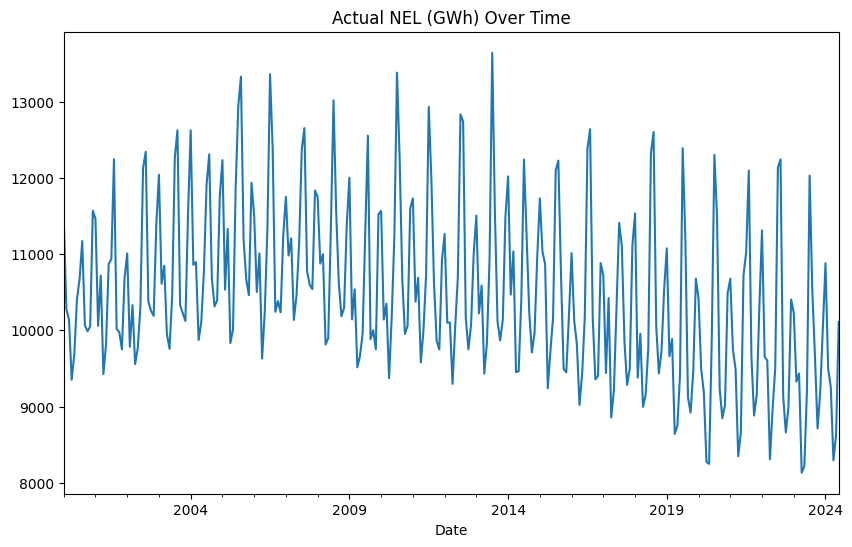

In [10]:
# Plot the data to understand the trend
data[target].plot(title='Actual NEL (GWh) Over Time', figsize=(10, 6))
plt.show()

In [11]:
# Convert all columns in the DataFrame to numeric, forcing any non-numeric data to NaN
train_data_numeric = train_data.apply(pd.to_numeric, errors='coerce')
val_data_single_numeric = val_data_single.apply(pd.to_numeric, errors='coerce')
val_data_multi_numeric = val_data_multi.apply(pd.to_numeric, errors='coerce')
test_data_single_numeric = test_data_single.apply(pd.to_numeric, errors='coerce')
test_data_multi_numeric = test_data_multi.apply(pd.to_numeric, errors='coerce')

# Drop or fill NaN values if any
train_data_numeric = train_data_numeric.dropna()
val_data_single_numeric = val_data_single_numeric.dropna()
val_data_multi_numeric = val_data_multi_numeric.dropna()
test_data_single_numeric = test_data_single_numeric.dropna()
test_data_multi_numeric = test_data_multi_numeric.dropna()

In [12]:
# # Define parameter grid for GridSearchCV for RandomForest model
# param_grid_rf = {
#     'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],      # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],        # Minimum number of samples required to be at a leaf node
#     'bootstrap': [True, False],           # Whether bootstrap samples are used when building trees
#     'max_features': ['sqrt', 'log2'],     # The number of features to consider when looking for the best split
#     'min_weight_fraction_leaf': [0.0, 0.01],  # Minimum weighted fraction of the input samples required to be at a leaf node
# }

# # Avoid using 'max_samples' when 'bootstrap=False'
# if 'max_samples' in param_grid_rf:
#     if False in param_grid_rf['bootstrap']:
#         param_grid_rf['max_samples'] = [None, 0.5, 0.75]  # Use only when bootstrap=True

# # Random Forest Grid Search
# grid_search_rf = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     param_grid=param_grid_rf,
#     cv=3,  # 3-fold cross-validation
#     n_jobs=-1,  # Use all available cores
#     verbose=2,
#     error_score='raise'  # Set error_score to 'raise' to debug failing fits
# )

In [13]:
param_grid_rf = {
     # Number of trees in the forest
    'n_estimators': [100, 150, 200, 250, 300],  
    # Maximum depth of the tree  
    'max_depth': [None, 10, 20, 30],     
    # Minimum number of samples required to split an internal node         
    'min_samples_split': [2, 5, 10],      
    # Minimum number of samples required to split an internal node         
    'min_samples_leaf': [1, 2, 4],                 
    # Whether bootstrap samples are used when building trees
    'bootstrap': [True, False]                     
}
# param_grid_rf = {
#     'n_estimators': [100, 150, 200, 250, 300],# Number of trees in the forest
#     'max_depth': [None, 10, 20, 30],          # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],          # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],            # Minimum number of samples required to be at a leaf node
#     'bootstrap': [True, False],               # Whether bootstrap samples are used when building trees
#     'max_features': ['sqrt', 'log2'],         # The number of features to consider when looking for the best split
#     'min_weight_fraction_leaf': [0.0, 0.01],  # Minimum weighted fraction of the input samples required to be at a leaf node
# }

# param_grid_rf = {
#     'n_estimators': [150],
#     'max_depth': [10],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'bootstrap': [True]
# }

# param_grid_rf = {
#     'n_estimators': [250],
#     'max_depth': [None],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1],
#     'bootstrap': [False]
# }

# Random Forest Grid Search
# grid_search_rf = GridSearchCV(
#     estimator=RandomForestRegressor(random_state=42),
#     param_grid=param_grid_rf,
#     cv=3,       # 3-fold cross-validation
#     n_jobs=-1,  # Use all available cores
#     verbose=2,
# )

# Avoid using 'max_samples' when 'bootstrap=False'
if 'max_samples' in param_grid_rf:
    if False in param_grid_rf['bootstrap']:
        param_grid_rf['max_samples'] = [None, 0.5, 0.75]  # Use only when bootstrap=True

# Random Forest Grid Search
grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    # 3-fold cross-validation
    cv=3,       
    # Use all available cores
    n_jobs=-1,  
    verbose=2,
    # Set error_score to 'raise' to debug failing fits
    # error_score='raise' 
)

# Perform grid search for randomforesting model
grid_search_rf.fit(X_train, y_train)

# Best hyperparameters for randomforesting model
best_params_rf = grid_search_rf.best_params_
print(f'Best parameters for randomforesting model: {best_params_rf}')

# Train the best randomforesting model
best_rf_model = RandomForestRegressor(**best_params_rf, random_state=42)
best_rf_model.fit(X_train, y_train)

# Randomforesting model evaluation on validation set
y_val_randomforest_single = best_rf_model.predict(X_val_single)
val_randomforest_mae_single = mean_absolute_error(y_val_single, y_val_randomforest_single)
val_randomforest_mse_single = mean_squared_error(y_val_single, y_val_randomforest_single)
val_randomforest_mape_single = mean_absolute_percentage_error(y_val_single, y_val_randomforest_single)
val_randomforest_rmse_single = rmse(y_val_single, y_val_randomforest_single)
val_randomforest_r2_single = r2_score(y_val_single, y_val_randomforest_single)
val_randomforest_mbd_single = mean_bias_deviation(y_val_single, y_val_randomforest_single)
val_randomforest_smape_single = smape(y_val_single, y_val_randomforest_single)

print(f'Random Forest Single Year:')
print(f'Validation MAE (Randomforest): {val_randomforest_mae_single}')
print(f'Validation MSE (Randomforest): {val_randomforest_mse_single}')
print(f'Validation MAPE (Randomforest): {val_randomforest_mape_single}')
print(f'Validation RMSE (Randomforest): {val_randomforest_rmse_single}')
print(f'Validation R² (Randomforest): {val_randomforest_r2_single}')
print(f'Validation MBD (Randomforest): {val_randomforest_mbd_single}')
print(f'Validation sMAPE (Randomforest): {val_randomforest_smape_single}')

# Randomforesting model evaluation on validation set
y_val_randomforest_multi = best_rf_model.predict(X_val_multi)
val_randomforest_mae_multi = mean_absolute_error(y_val_multi, y_val_randomforest_multi)
val_randomforest_mse_multi = mean_squared_error(y_val_multi, y_val_randomforest_multi)
val_randomforest_mape_multi= mean_absolute_percentage_error(y_val_multi, y_val_randomforest_multi)
val_randomforest_rmse_multi = rmse(y_val_multi, y_val_randomforest_multi)
val_randomforest_r2_multi = r2_score(y_val_multi, y_val_randomforest_multi)
val_randomforest_mbd_multi = mean_bias_deviation(y_val_multi, y_val_randomforest_multi)
val_randomforest_smape_multi = smape(y_val_multi, y_val_randomforest_multi)

print(f'Random Forest Multi Year:')
print(f'Validation MAE (Randomforest): {val_randomforest_mae_multi}')
print(f'Validation MSE (Randomforest): {val_randomforest_mse_multi}')
print(f'Validation MAPE (Randomforest): {val_randomforest_mape_multi}')
print(f'Validation RMSE (Randomforest): {val_randomforest_rmse_multi}')
print(f'Validation R² (Randomforest): {val_randomforest_r2_multi}')
print(f'Validation MBD (Randomforest): {val_randomforest_mbd_multi}')
print(f'Validation sMAPE (Randomforest): {val_randomforest_smape_multi}')

# Test the Randomforesting model(Single Year)
y_test_randomforest_single = best_rf_model.predict(X_test_single)
test_randomforest_mae_single = mean_absolute_error(y_test_single, y_test_randomforest_single)
test_randomforest_mse_single = mean_squared_error(y_test_single, y_test_randomforest_single)
test_randomforest_mape_single = mean_absolute_percentage_error(y_test_single, y_test_randomforest_single)
test_randomforest_rmse_single = rmse(y_test_single, y_test_randomforest_single)
test_randomforest_r2_single = r2_score(y_test_single, y_test_randomforest_single)
test_randomforest_mbd_single = mean_bias_deviation(y_test_single, y_test_randomforest_single)
test_randomforest_smape_single = smape(y_test_single, y_test_randomforest_single)

print(f'Random Forest Single Year:')
print(f'Test MAE (Randomforest): {test_randomforest_mae_single}')
print(f'Test MSE (Randomforest): {test_randomforest_mse_single}')
print(f'Test MAPE (Randomforest): {test_randomforest_mape_single}')
print(f'Test RMSE (Randomforest): {test_randomforest_rmse_single}')
print(f'Test R² (Randomforest): {test_randomforest_r2_single}')
print(f'Test MBD (Randomforest): {test_randomforest_mbd_single}')
print(f'Test sMAPE (Randomforest): {test_randomforest_smape_single}')

y_test_randomforest_multi = best_rf_model.predict(X_test_multi)
test_randomforest_mae_multi = mean_absolute_error(y_test_multi, y_test_randomforest_multi)
test_randomforest_mse_multi = mean_squared_error(y_test_multi, y_test_randomforest_multi)
test_randomforest_mape_multi = mean_absolute_percentage_error(y_test_multi, y_test_randomforest_multi)
test_randomforest_rmse_multi = rmse(y_test_multi, y_test_randomforest_multi)
test_randomforest_r2_multi = r2_score(y_test_multi, y_test_randomforest_multi)
test_randomforest_mbd_multi = mean_bias_deviation(y_test_multi, y_test_randomforest_multi)
test_randomforest_smape_multi = smape(y_test_multi, y_test_randomforest_multi)

print(f'Random Forest Multi-Years:')
print(f'Test MAE (Randomforest): {test_randomforest_mae_multi}')
print(f'Test MSE (Randomforest): {test_randomforest_mse_multi}')
print(f'Test MAPE (Randomforest): {test_randomforest_mape_multi}')
print(f'Test RMSE (Randomforest): {test_randomforest_rmse_multi}')
print(f'Test R² (Randomforest): {test_randomforest_r2_multi}')
print(f'Test MBD (Randomforest): {test_randomforest_mbd_multi}')
print(f'Test sMAPE (Randomforest): {test_randomforest_smape_multi}')


Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters for randomforesting model: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest Single Year:
Validation MAE (Randomforest): 33.075444444445715
Validation MSE (Randomforest): 1838.9485638518624
Validation MAPE (Randomforest): 0.0033531610915354857
Validation RMSE (Randomforest): 42.88296356190722
Validation R² (Randomforest): 0.9986551066000329
Validation MBD (Randomforest): -4.16677777777674
Validation sMAPE (Randomforest): 0.3348698668919531
Random Forest Multi Year:
Validation MAE (Randomforest): 114.92222222222252
Validation MSE (Randomforest): 61739.24878396291
Validation MAPE (Randomforest): 0.01311604447572596
Validation RMSE (Randomforest): 248.4738392345619
Validation R² (Randomforest): 0.9579171703720406
Validation MBD (Randomforest): -74.23794444444236
Validation sMAPE (Randomforest): 1.2703186178801542
Random Forest Single Year:


In [14]:
# # Define parameter grid for GridSearchCV for error correction model
# param_grid_rfec = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [10, 20, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Initialize GridSearchCV for error correction model
# grid_search_rfec = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
#                               param_grid=param_grid_rfec,
#                               cv=3,
#                               n_jobs=-1,
#                               verbose=2)

# # Perform grid search for error correction model
# grid_search_rfec.fit(X_error_correction_train, y_error_correction_train)

# # Best hyperparameters for error correction model
# best_params_rfec = grid_search_rfec.best_params_
# print(f'Best parameters for error correction model: {best_params_rfec}')

# # Train the best error correction model
# best_rfec_model = RandomForestRegressor(**best_params_rfec, random_state=42)
# best_rfec_model.fit(X_error_correction_train, y_error_correction_train)

# # Error correction model evaluation on validation set
# y_val_corrected = best_rfec_model.predict(X_val)
# val_corrected_mae = mean_absolute_error(y_val, y_val_corrected)
# val_corrected_mse = mean_squared_error(y_val, y_val_corrected)
# val_corrected_mape = mean_absolute_percentage_error(y_val, y_val_corrected)
# val_corrected_rmse = rmse(y_val, y_val_corrected)
# val_corrected_r2 = r2_score(y_val, y_val_corrected)
# val_corrected_mbd = mean_bias_deviation(y_val, y_val_corrected)
# val_corrected_smape = smape(y_val, y_val_corrected)

# print(f'Validation MAE (RF Error Correction): {val_corrected_mae}')
# print(f'Validation MSE (RF Error Correction): {val_corrected_mse}')
# print(f'Validation MAPE (RF Error Correction): {val_corrected_mape}')
# print(f'Validation RMSE (RF Error Correction): {val_corrected_rmse}')
# print(f'Validation R² (RF Error Correction): {val_corrected_r2}')
# print(f'Validation MBD (RF Error Correction): {val_corrected_mbd}')
# print(f'Validation sMAPE (RF Error Correction): {val_corrected_smape}')

# # Test the error correction model
# y_test_corrected = best_rfec_model.predict(X_test)
# test_corrected_mae = mean_absolute_error(y_test, y_test_corrected)
# test_corrected_mse = mean_squared_error(y_test, y_test_corrected)
# test_corrected_mape = mean_absolute_percentage_error(y_test, y_test_corrected)
# test_corrected_rmse = rmse(y_test, y_test_corrected)
# test_corrected_r2 = r2_score(y_test, y_test_corrected)
# test_corrected_mbd = mean_bias_deviation(y_test, y_test_corrected)
# test_corrected_smape = smape(y_test, y_test_corrected)

# print(f'Test MAE (RF Error Correction): {test_corrected_mae}')
# print(f'Test MSE (RF Error Correction): {test_corrected_mse}')
# print(f'Test MAPE (RF Error Correction): {test_corrected_mape}')
# print(f'Test RMSE (RF Error Correction): {test_corrected_rmse}')
# print(f'Test R² (RF Error Correction): {test_corrected_r2}')
# print(f'Test MBD (RF Error Correction): {test_corrected_mbd}')
# print(f'Test sMAPE (RF Error Correction): {test_corrected_smape}')

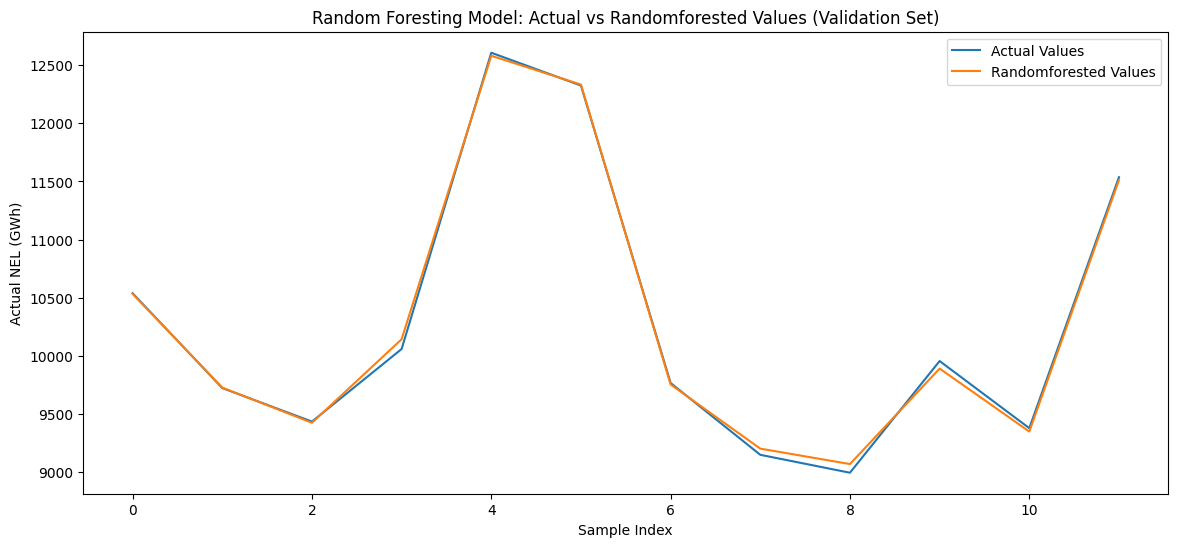

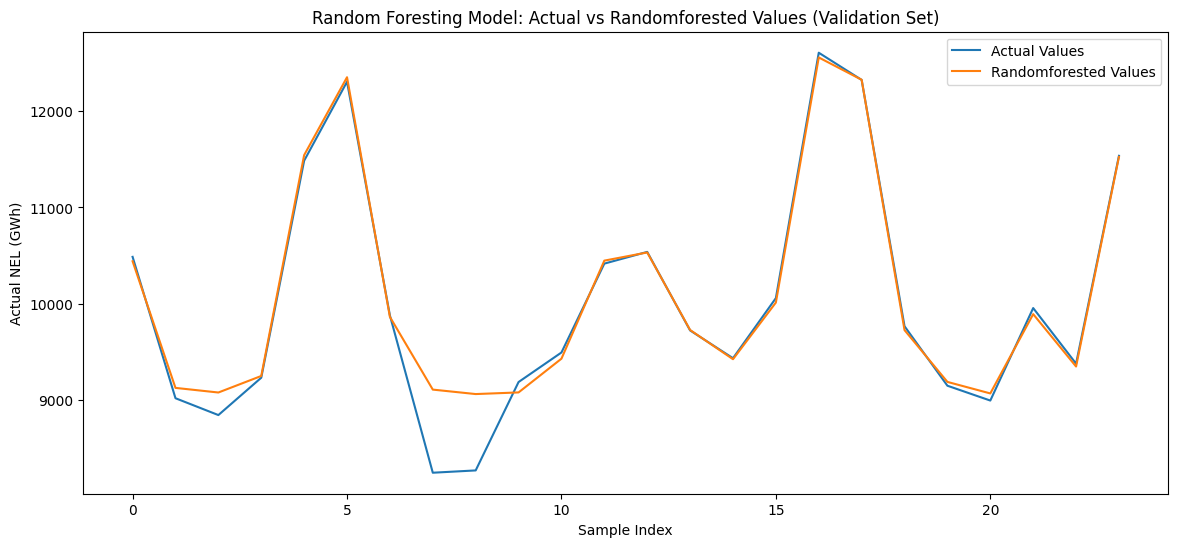

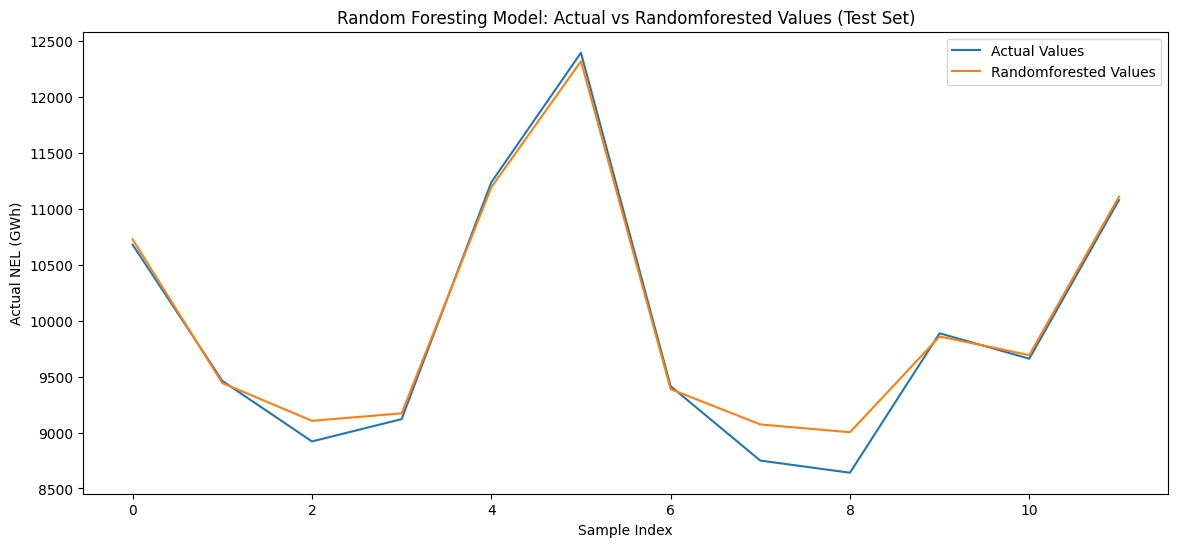

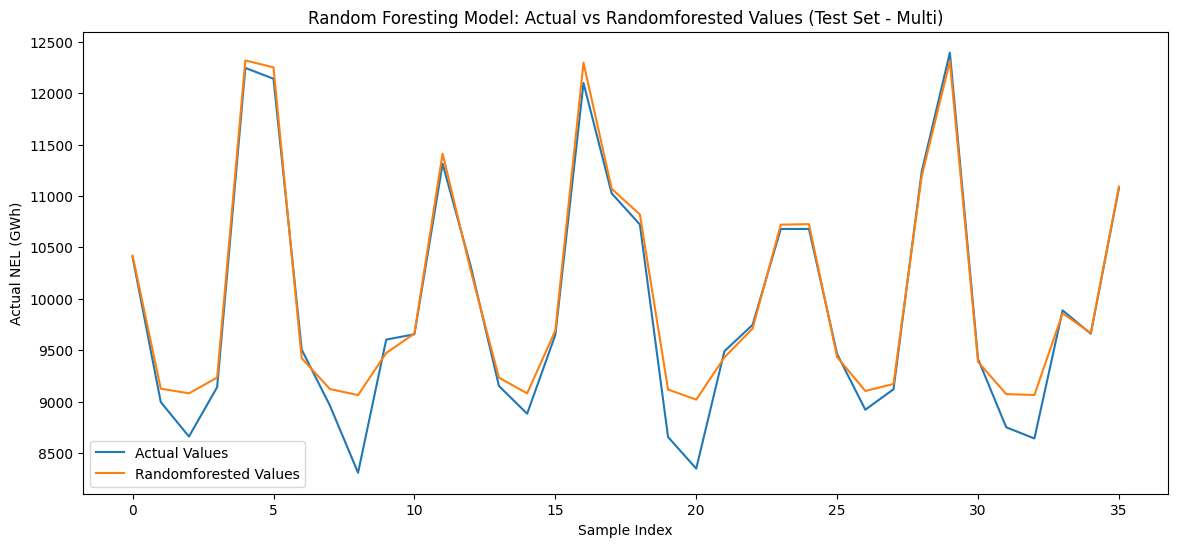

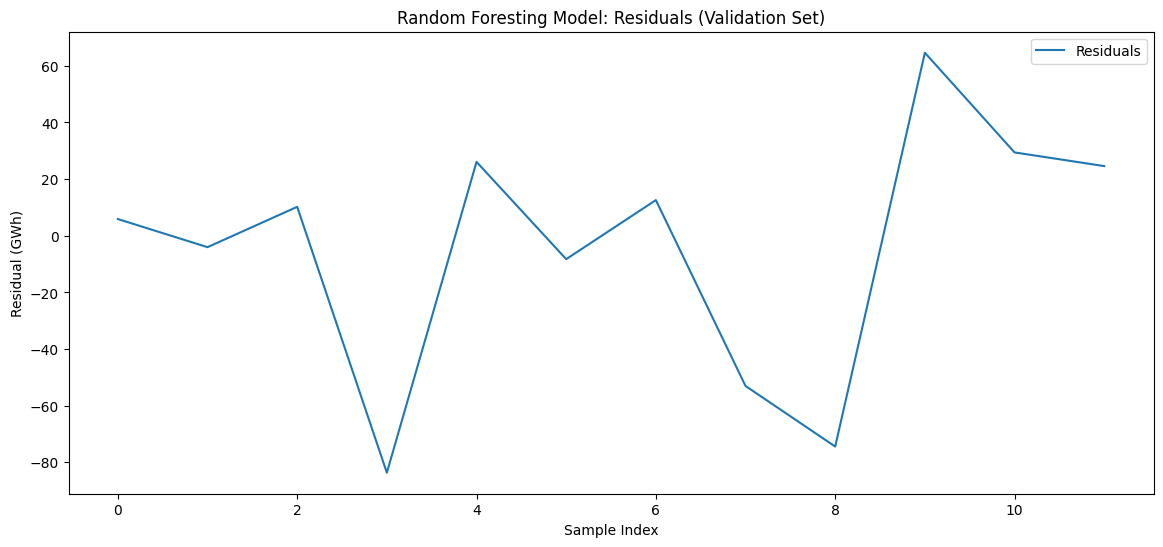

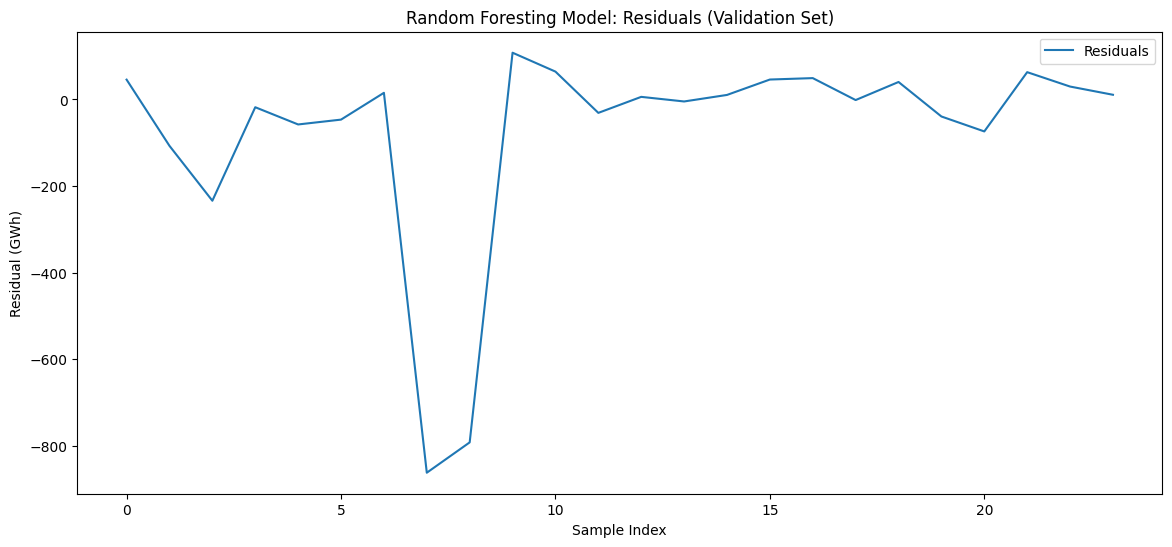

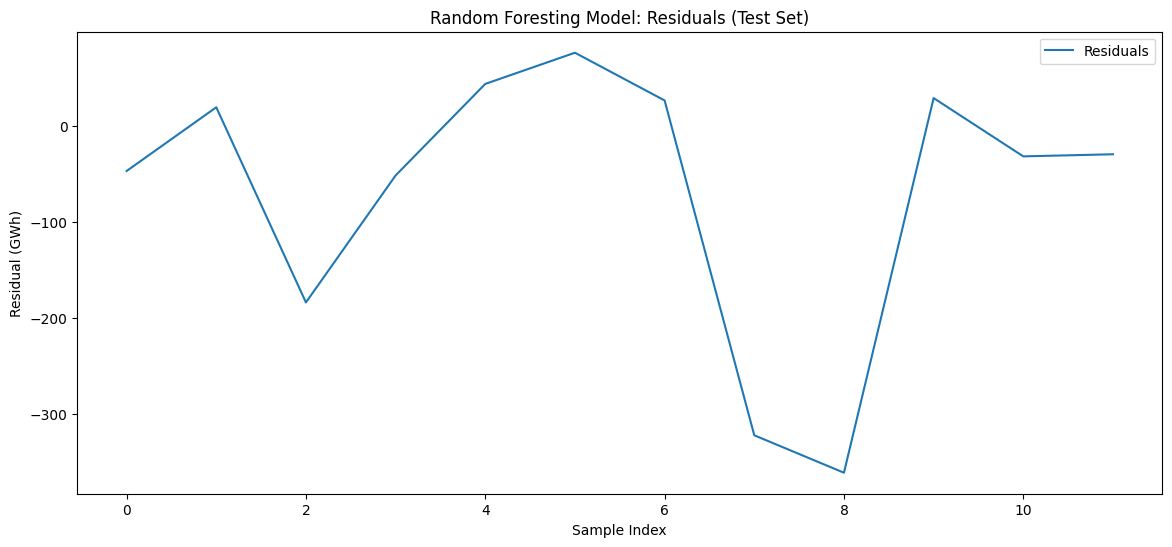

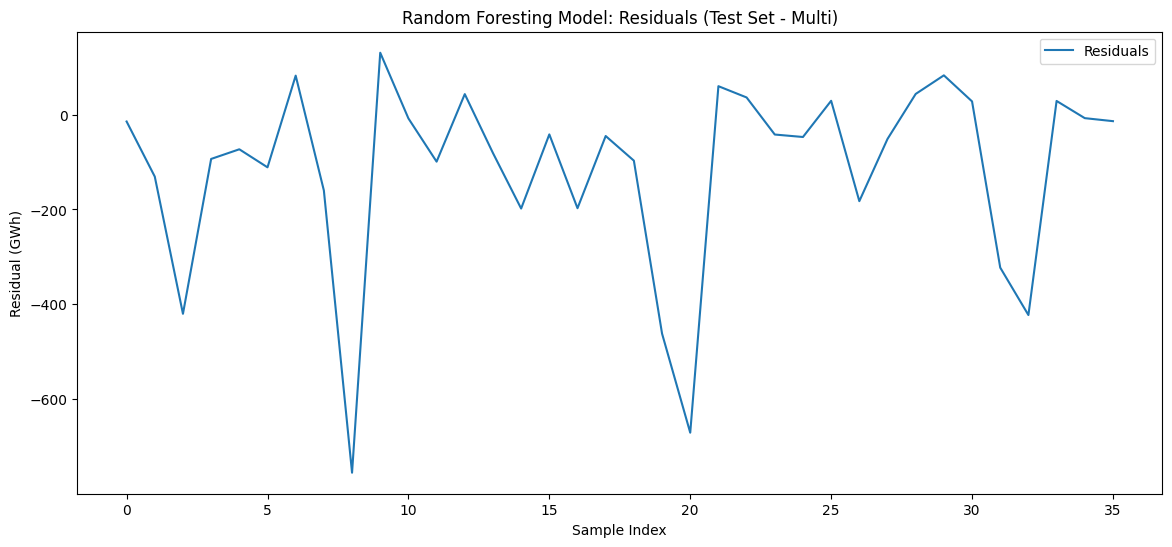

In [15]:
# Plot actual vs. predicted values for the validation set (Randomforesting Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_val_single.values, label='Actual Values')
plt.plot(y_val_randomforest_single, label='Randomforested Values')
plt.title('Random Foresting Model: Actual vs Randomforested Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMavpVS_S.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the validation set (Randomforesting Model - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_val_multi.values, label='Actual Values')
plt.plot(y_val_randomforest_multi, label='Randomforested Values')
plt.title('Random Foresting Model: Actual vs Randomforested Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMavpVS_M.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (Randomforesting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test_single.values, label='Actual Values')
plt.plot(y_test_randomforest_single, label='Randomforested Values')
plt.title('Random Foresting Model: Actual vs Randomforested Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMavpTS_S.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (Randomforesting Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test_multi.values, label='Actual Values')
plt.plot(y_test_randomforest_multi, label='Randomforested Values')
plt.title('Random Foresting Model: Actual vs Randomforested Values (Test Set - Multi)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMavpTS_M.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (Randomforesting Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_val_single.values - y_val_randomforest_single, label='Residuals')
plt.title('Random Foresting Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMrVS_S.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (Randomforesting Model - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_val_multi.values - y_val_randomforest_multi, label='Residuals')
plt.title('Random Foresting Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMrVS_M.png'))
plt.show()
plt.close()

# Plot residuals for the test set (Randomforesting Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_test_single.values - y_test_randomforest_single, label='Residuals')
plt.title('Random Foresting Model: Residuals (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMrTS_S.png'))
plt.show()
plt.close()

# Plot residuals for the test set (Randomforesting Model - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_test_multi.values - y_test_randomforest_multi, label='Residuals')
plt.title('Random Foresting Model: Residuals (Test Set - Multi)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'RFMrTS_M.png'))
plt.show()
plt.close()

In [16]:
# print("Validation Set - True vs Predicted Values (Random Forest):")
# for true_val, pred_val in zip(y_val.values, y_val_forecast):
#     print(f"True: {true_val}, Predicted: {pred_val}")

# # Print true vs predicted values for the test set(Single)
# print("\nTest Set - True vs Predicted Values (Random Forest - Single):")
# for true_val, pred_val in zip(y_test_single.values, y_test_forecast):
#     print(f"True: {true_val}, Predicted: {pred_val}")

# # Print true vs predicted values for the test set(Multi)
# print("\nTest Set - True vs Predicted Values (Random Forest - Multi):")
# for true_val, pred_val in zip(y_test_multi.values, y_test_forecast):
#     print(f"True: {true_val}, Predicted: {pred_val}")


In [17]:
# # Get feature importances
# feature_importances = best_rf_model.feature_importances_
# # features_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
# features_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': feature_importances})
# features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

# # Plot feature importances
# plt.figure(figsize=(10, 6))
# sns.barplot(x='Importance', y='Feature', data=features_importance_df)
# plt.title('Feature Importances')
# plt.show()

# # Display feature importances
# print(features_importance_df)

In [18]:
# Plot actual vs. predicted values for the validation set (RF Error Correction Model)
# plt.figure(figsize=(14, 6))
# plt.plot(y_val.values, label='Actual Values')
# plt.plot(y_val_corrected, label='Corrected Values')
# plt.title('RF Error Correction Model: Actual vs Corrected Values (Validation Set)')
# plt.xlabel('Sample Index')
# plt.ylabel('Actual NEL (GWh)')
# plt.legend()
# plt.savefig(os.path.join(output_dir, 'RFECMavpVS.png'))
# plt.show()
# plt.close()

# Plot actual vs. predicted values for the test set (RF Error Correction Model)
# plt.figure(figsize=(14, 6))
# plt.plot(y_test.values, label='Actual Values')
# plt.plot(y_test_corrected, label='Corrected Values')
# plt.title('RF Error Correction Model: Actual vs Corrected Values (Test Set)')
# plt.xlabel('Sample Index')
# plt.ylabel('Actual NEL (GWh)')
# plt.legend()
# plt.savefig(os.path.join(output_dir, 'RFECMavpTS.png'))
# plt.show()
# plt.close()

# Plot residuals for the validation set (RF Error Correction Model)
# plt.figure(figsize=(14, 6))
# plt.plot(y_val.values - y_val_corrected, label='Residuals')
# plt.title('RF Error Correction Model: Residuals (Validation Set)')
# plt.xlabel('Sample Index')
# plt.ylabel('Residual (GWh)')
# plt.legend()
# plt.savefig(os.path.join(output_dir, 'RFECMrVS.png'))
# plt.show()
# plt.close()

# Plot residuals for the test set (RF Error Correction Model)
# plt.figure(figsize=(14, 6))
# plt.plot(y_test.values - y_test_corrected, label='Residuals')
# plt.title('RF Error Correction Model: Residuals (Test Set)')
# plt.xlabel('Sample Index')
# plt.ylabel('Residual (GWh)')
# plt.legend()
# plt.savefig(os.path.join(output_dir, 'RFECMrTS.png'))
# plt.show()
# plt.close()

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

# Define parameter grid for GridSearchCV for Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define parameter grid for GridSearchCV for Gradient Boosting
# param_grid_gb = {
#     'n_estimators': [100, 200, 300, 400],          # Number of boosting stages to be run
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],       # Learning rate shrinks the contribution of each tree
#     'max_depth': [3, 5, 7, 10],                    # Maximum depth of the tree
#     'min_samples_split': [2, 5, 10],               # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],                 # Minimum number of samples required to be at a leaf node
#     'subsample': [0.8, 1.0],                       # Fraction of samples used for fitting the individual base learners
#     'max_features': ['sqrt', 'log2', None],        # Number of features to consider when looking for the best split
#     'loss': ['ls', 'lad', 'huber'],
#     'alpha': [0.9, 0.95, 0.99]
# }

# param_grid_gb = {
#     'n_estimators': [300],
#     'learning_rate': [0.1],
#     'max_depth': [3],
#     'min_samples_split': [10],
#     'min_samples_leaf': [1]
# }

# Gradient Boosting Grid Search
grid_search_gb = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid_gb,
    cv=3,       # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=2
)

# Perform grid search for Gradient Boosting model
grid_search_gb.fit(X_train, y_train)

# Best hyperparameters for Gradient Boosting model
best_params_gb = grid_search_gb.best_params_
print(f'Best parameters for Gradient Boosting model: {best_params_gb}')

# Train the best Gradient Boosting model
best_gradientboosting_model = GradientBoostingRegressor(**best_params_gb, random_state=42)
best_gradientboosting_model.fit(X_train, y_train)

# Gradient Boosting model evaluation on validation set(Single Year)
y_val_gradientboost_single = best_gradientboosting_model.predict(X_val_single)
val_gradientboost_mae_single = mean_absolute_error(y_val_single, y_val_gradientboost_single)
val_gradientboost_mse_single = mean_squared_error(y_val_single, y_val_gradientboost_single)
val_gradientboost_mape_single = mean_absolute_percentage_error(y_val_single, y_val_gradientboost_single)
val_gradientboost_rmse_single = rmse(y_val_single, y_val_gradientboost_single)
val_gradientboost_r2_single = r2_score(y_val_single, y_val_gradientboost_single)
val_gradientboost_mbd_single= mean_bias_deviation(y_val_single, y_val_gradientboost_single)
val_gradientboost_smape_single = smape(y_val_single, y_val_gradientboost_single)

print(f'Gradient Boost Single Year:')
print(f'Validation MAE (Gradient Boosting): {val_gradientboost_mae_single}')
print(f'Validation MSE (Gradient Boosting): {val_gradientboost_mse_single}')
print(f'Validation MAPE (Gradient Boosting): {val_gradientboost_mape_single}')
print(f'Validation RMSE (Gradient Boosting): {val_gradientboost_rmse_single}')
print(f'Validation R² (Gradient Boosting): {val_gradientboost_r2_single}')
print(f'Validation MBD (Gradient Boosting): {val_gradientboost_mbd_single}')
print(f'Validation sMAPE (Gradient Boosting): {val_gradientboost_smape_single}')

# Gradient Boosting model evaluation on validation set(Multi Year)
y_val_gradientboost_multi = best_gradientboosting_model.predict(X_val_multi)
val_gradientboost_mae_multi = mean_absolute_error(y_val_multi, y_val_gradientboost_multi)
val_gradientboost_mse_multi = mean_squared_error(y_val_multi, y_val_gradientboost_multi)
val_gradientboost_mape_multi = mean_absolute_percentage_error(y_val_multi, y_val_gradientboost_multi)
val_gradientboost_rmse_multi = rmse(y_val_multi, y_val_gradientboost_multi)
val_gradientboost_r2_multi = r2_score(y_val_multi, y_val_gradientboost_multi)
val_gradientboost_mbd_multi = mean_bias_deviation(y_val_multi, y_val_gradientboost_multi)
val_gradientboost_smape_multi = smape(y_val_multi, y_val_gradientboost_multi)

print(f'Gradient Boost Multi-Year:')
print(f'Validation MAE (Gradient Boosting): {val_gradientboost_mae_multi}')
print(f'Validation MSE (Gradient Boosting): {val_gradientboost_mse_multi}')
print(f'Validation MAPE (Gradient Boosting): {val_gradientboost_mape_multi}')
print(f'Validation RMSE (Gradient Boosting): {val_gradientboost_rmse_multi}')
print(f'Validation R² (Gradient Boosting): {val_gradientboost_r2_multi}')
print(f'Validation MBD (Gradient Boosting): {val_gradientboost_mbd_multi}')
print(f'Validation sMAPE (Gradient Boosting): {val_gradientboost_smape_multi}')

# Test the Gradient Boosting model(Single Year)
y_test_gradientboost_single = best_gradientboosting_model.predict(X_test_single)
test_gradientboost_mae_single = mean_absolute_error(y_test_single, y_test_gradientboost_single)
test_gradientboost_mse_single = mean_squared_error(y_test_single, y_test_gradientboost_single)
test_gradientboost_mape_single = mean_absolute_percentage_error(y_test_single, y_test_gradientboost_single)
test_gradientboost_rmse_single = rmse(y_test_single, y_test_gradientboost_single)
test_gradientboost_r2_single = r2_score(y_test_single, y_test_gradientboost_single)
test_gradientboost_mbd_single = mean_bias_deviation(y_test_single, y_test_gradientboost_single)
test_gradientboost_smape_single = smape(y_test_single, y_test_gradientboost_single)

print(f'Gradient Boost Single Year:')
print(f'Test MAE (Gradient Boosting): {test_gradientboost_mae_single}')
print(f'Test MSE (Gradient Boosting): {test_gradientboost_mse_single}')
print(f'Test MAPE (Gradient Boosting): {test_gradientboost_mape_single}')
print(f'Test RMSE (Gradient Boosting): {test_gradientboost_rmse_single}')
print(f'Test R² (Gradient Boosting): {test_gradientboost_r2_single}')
print(f'Test MBD (Gradient Boosting): {test_gradientboost_mbd_single}')
print(f'Test sMAPE (Gradient Boosting): {test_gradientboost_smape_single}')

# Test the Gradient Boosting model(Multi Year)
y_test_gradientboost_multi = best_gradientboosting_model.predict(X_test_multi)
test_gradientboost_mae_multi = mean_absolute_error(y_test_multi, y_test_gradientboost_multi)
test_gradientboost_mse_multi = mean_squared_error(y_test_multi, y_test_gradientboost_multi)
test_gradientboost_mape_multi = mean_absolute_percentage_error(y_test_multi, y_test_gradientboost_multi)
test_gradientboost_rmse_multi = rmse(y_test_multi, y_test_gradientboost_multi)
test_gradientboost_r2_multi = r2_score(y_test_multi, y_test_gradientboost_multi)
test_gradientboost_mbd_multi = mean_bias_deviation(y_test_multi, y_test_gradientboost_multi)
test_gradientboost_smape_multi = smape(y_test_multi, y_test_gradientboost_multi)

print(f'Gradient Boost Multi-Year:')
print(f'Test MAE (Gradient Boosting): {test_gradientboost_mae_multi}')
print(f'Test MSE (Gradient Boosting): {test_gradientboost_mse_multi}')
print(f'Test MAPE (Gradient Boosting): {test_gradientboost_mape_multi}')
print(f'Test RMSE (Gradient Boosting): {test_gradientboost_rmse_multi}')
print(f'Test R² (Gradient Boosting): {test_gradientboost_r2_multi}')
print(f'Test MBD (Gradient Boosting): {test_gradientboost_mbd_multi}')
print(f'Test sMAPE (Gradient Boosting): {test_gradientboost_smape_multi}')

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best parameters for Gradient Boosting model: {'learning_rate': 0.2, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Gradient Boost Single Year:
Validation MAE (Gradient Boosting): 35.33056809147638
Validation MSE (Gradient Boosting): 1664.0019796668576
Validation MAPE (Gradient Boosting): 0.0034269168118707927
Validation RMSE (Gradient Boosting): 40.792180374023374
Validation R² (Gradient Boosting): 0.9987830517264177
Validation MBD (Gradient Boosting): -14.214660972938267
Validation sMAPE (Gradient Boosting): 0.3423578101152498
Gradient Boost Multi-Year:
Validation MAE (Gradient Boosting): 91.10804093466368
Validation MSE (Gradient Boosting): 43863.55082172415
Validation MAPE (Gradient Boosting): 0.010345001957348436
Validation RMSE (Gradient Boosting): 209.43626911718073
Validation R² (Gradient Boosting): 0.9701016391928073
Validation MBD (Gradient Boosting): -57.76012211683686
Validat

In [20]:
# # Define parameter grid for GridSearchCV for Gradient Boosting
# param_grid_gbec = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize GridSearchCV for Gradient Boosting model
# grid_search_gbec = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42),
#                               param_grid=param_grid_gbec,
#                               cv=3,
#                               n_jobs=-1,
#                               verbose=2)

# # Perform grid search for Gradient Boosting model
# grid_search_gbec.fit(X_error_correction_train, y_error_correction_train)

# # Best hyperparameters for Gradient Boosting model
# best_params_gbec = grid_search_gbec.best_params_
# print(f'Best parameters for Gradient Boosting model: {best_params_gbec}')

# # Train the best Gradient Boosting model
# best_gbec_model = GradientBoostingRegressor(**best_params_gbec, random_state=42)
# best_gbec_model.fit(X_error_correction_train, y_error_correction_train)

# # Gradient Boosting model evaluation on validation set
# y_val_corrected_gb = best_gbec_model.predict(X_val)
# val_corrected_gb_mae = mean_absolute_error(y_val, y_val_corrected_gb)
# val_corrected_gb_mse = mean_squared_error(y_val, y_val_corrected_gb)
# val_corrected_gb_mape = mean_absolute_percentage_error(y_val, y_val_corrected_gb)
# val_corrected_gb_rmse = rmse(y_val, y_val_corrected_gb)
# val_corrected_gb_r2 = r2_score(y_val, y_val_corrected_gb)
# val_corrected_gb_mbd = mean_bias_deviation(y_val, y_val_corrected_gb)
# val_corrected_gb_smape = smape(y_val, y_val_corrected_gb)

# print(f'Validation MAE (GB Error Correction): {val_corrected_gb_mae}')
# print(f'Validation MSE (GB Error Correction): {val_corrected_gb_mse}')
# print(f'Validation MAPE (GB Error Correction): {val_corrected_gb_mape}')
# print(f'Validation RMSE (GB Error Correction): {val_corrected_gb_rmse}')
# print(f'Validation R² (GB Error Correction): {val_corrected_gb_r2}')
# print(f'Validation MBD (GB Error Correction): {val_corrected_gb_mbd}')
# print(f'Validation sMAPE (GB Error Correction): {val_corrected_gb_smape}')

# # Test the Gradient Boosting model
# y_test_corrected_gb = best_gbec_model.predict(X_test)
# test_corrected_gb_mae = mean_absolute_error(y_test, y_test_corrected_gb)
# test_corrected_gb_mse = mean_squared_error(y_test, y_test_corrected_gb)
# test_corrected_gb_mape = mean_absolute_percentage_error(y_test, y_test_corrected_gb)
# test_corrected_gb_rmse = rmse(y_test, y_test_corrected_gb)
# test_corrected_gb_r2 = r2_score(y_test, y_test_corrected_gb)
# test_corrected_gb_mbd = mean_bias_deviation(y_test, y_test_corrected_gb)
# test_corrected_gb_smape = smape(y_test, y_test_corrected_gb)

# print(f'Test MAE (GB Error Correction): {test_corrected_gb_mae}')
# print(f'Test MSE (GB Error Correction): {test_corrected_gb_mse}')
# print(f'Test MAPE (GB Error Correction): {test_corrected_gb_mape}')
# print(f'Test RMSE (GB Error Correction): {test_corrected_gb_rmse}')
# print(f'Test R² (GB Error Correction): {test_corrected_gb_r2}')
# print(f'Test MBD (GB Error Correction): {test_corrected_gb_mbd}')
# print(f'Test sMAPE (GB Error Correction): {test_corrected_gb_smape}')

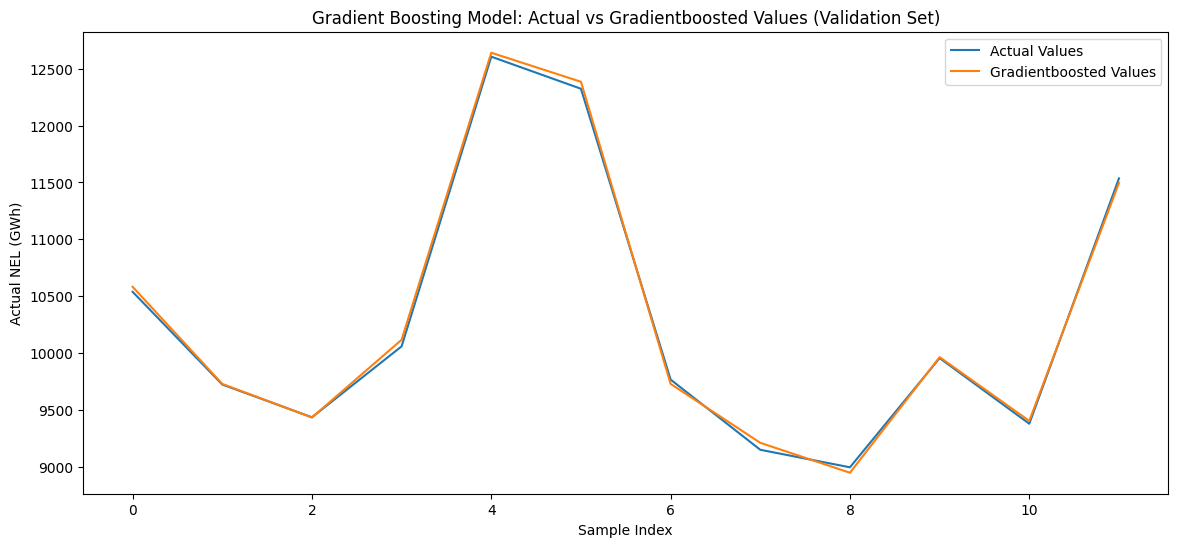

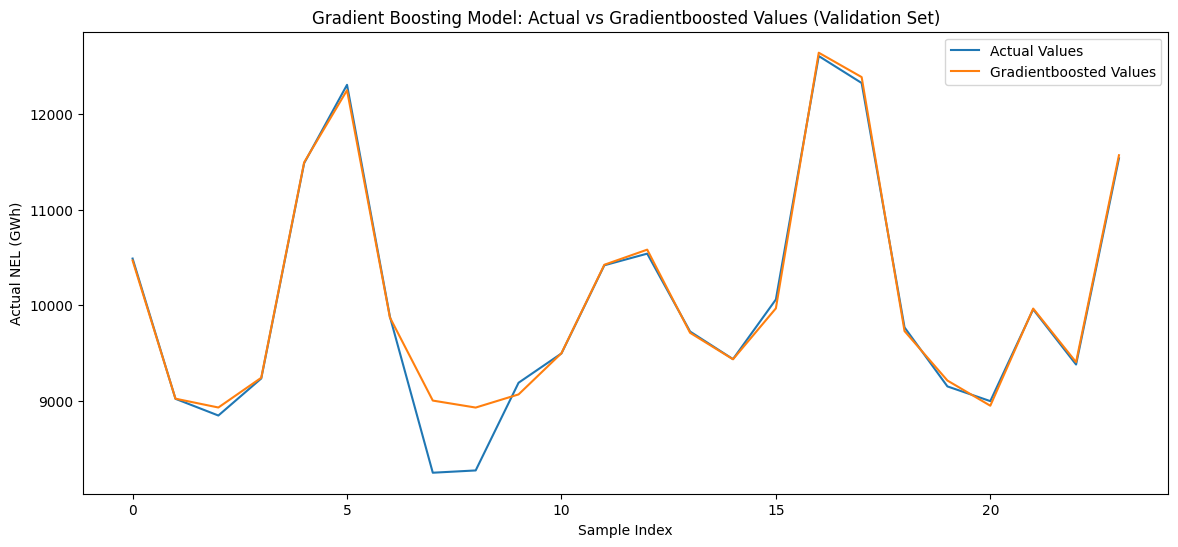

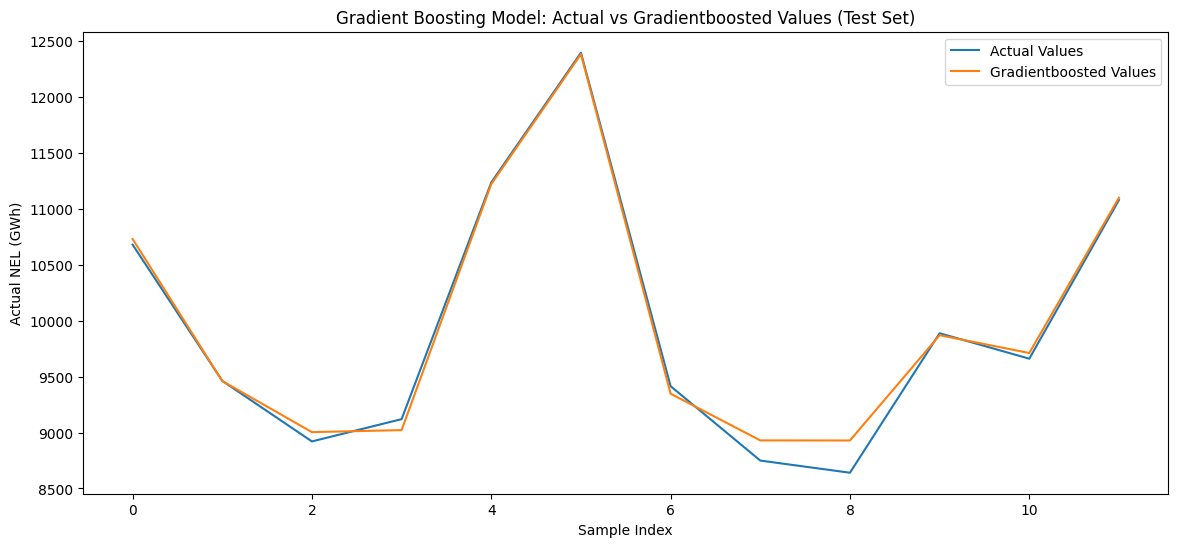

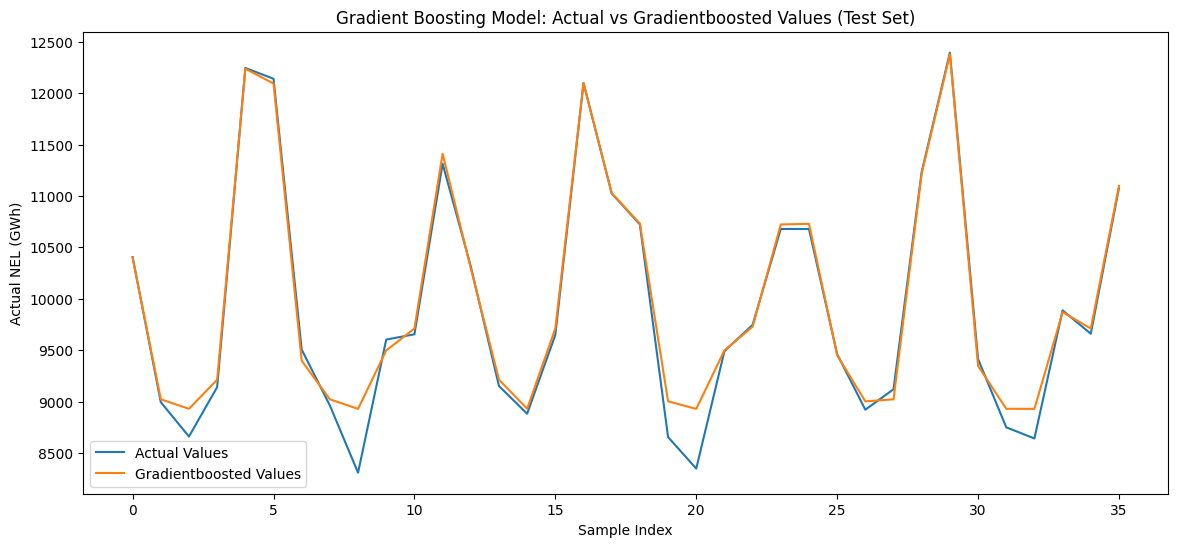

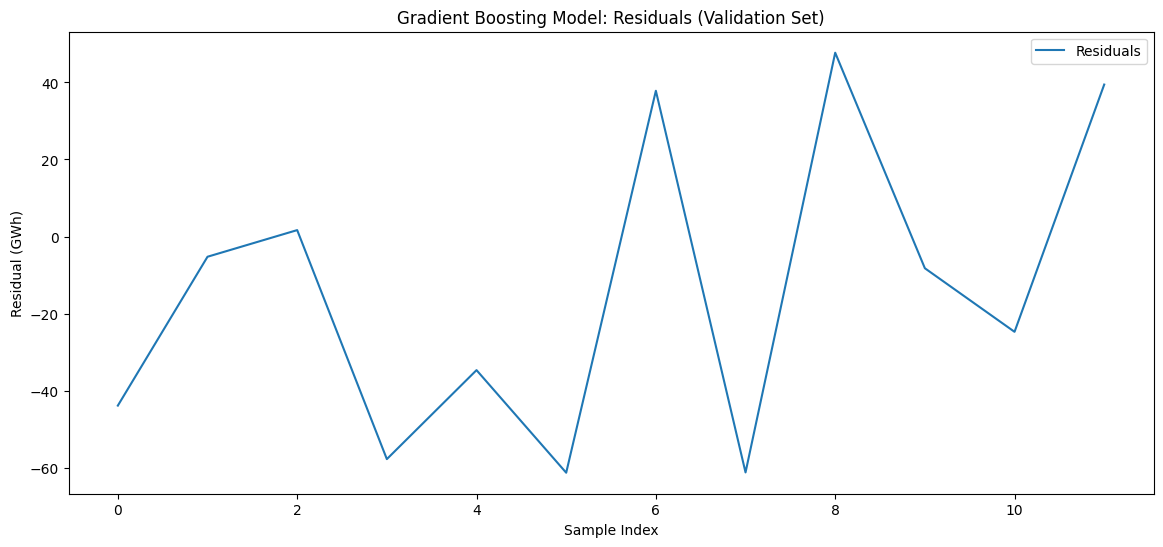

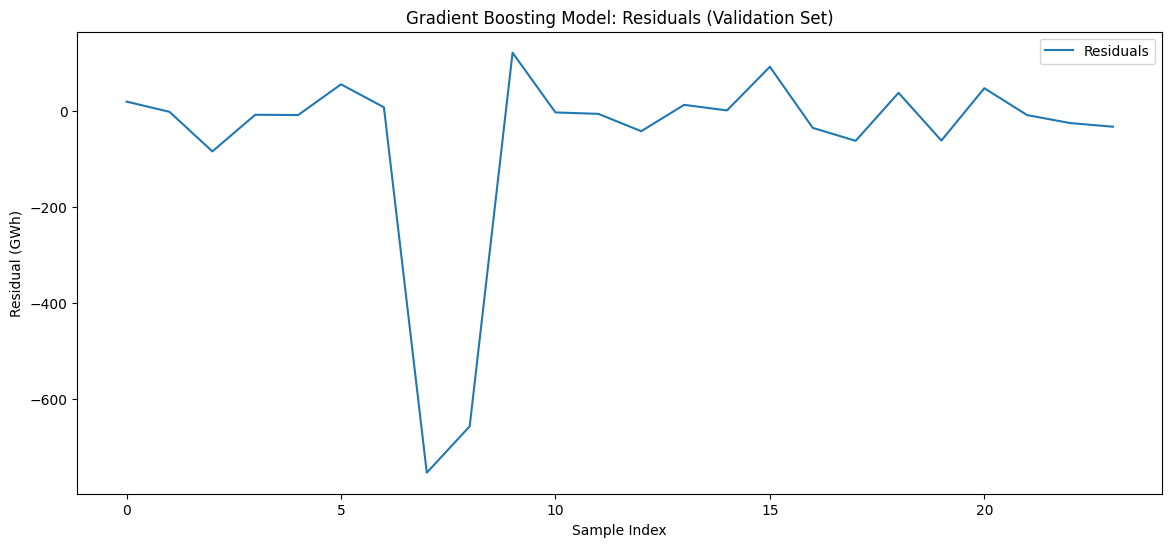

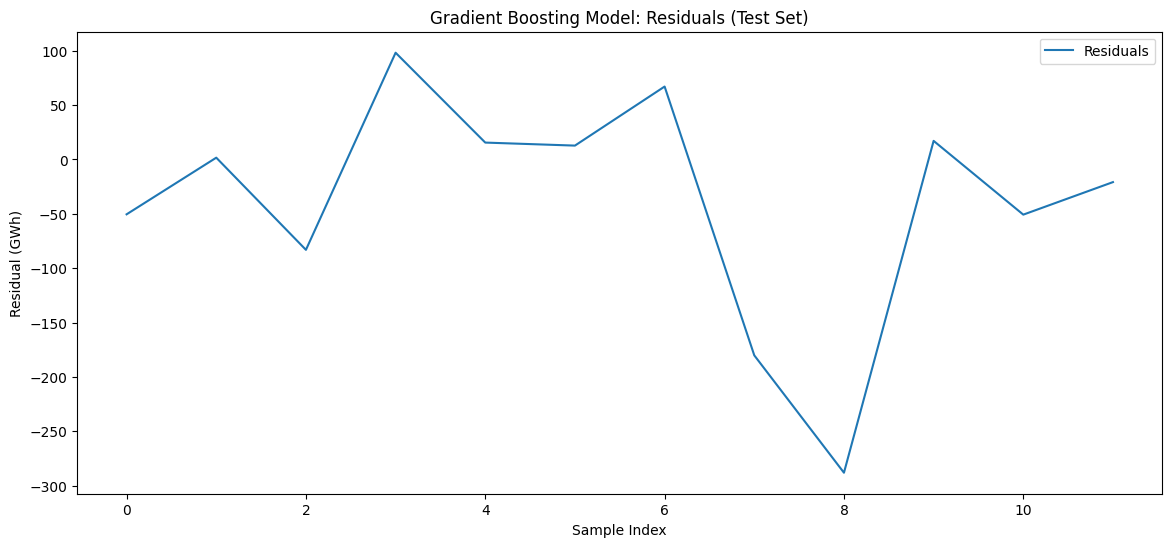

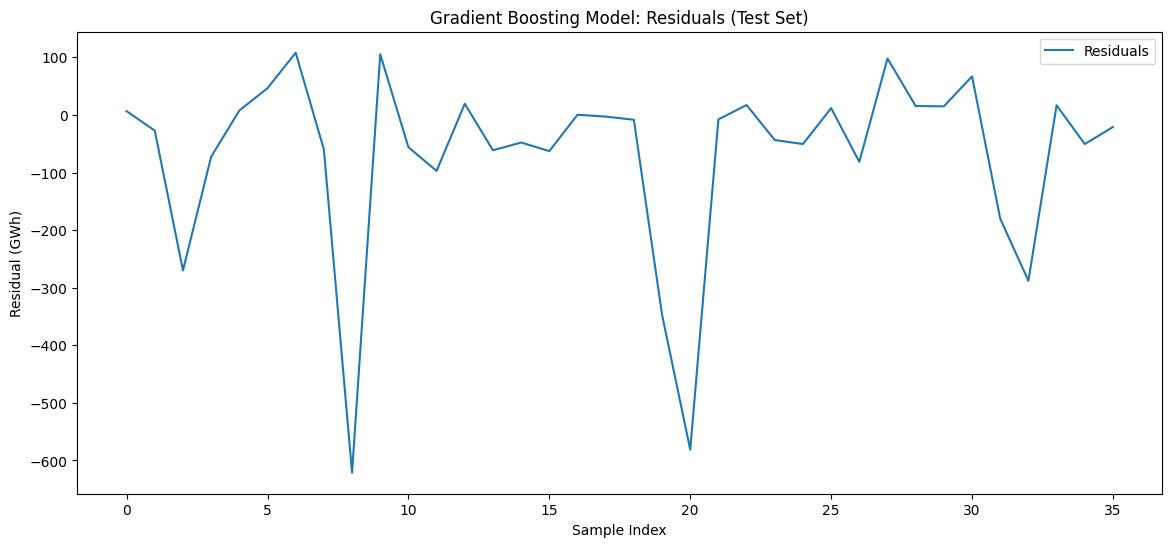

In [21]:
# Plot actual vs. predicted values for the validation set (Gradientboosting Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_val_single.values, label='Actual Values')
plt.plot(y_val_gradientboost_single, label='Gradientboosted Values')
plt.title('Gradient Boosting Model: Actual vs Gradientboosted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMavpVS_S.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the validation set (Gradientboosting Model - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_val_multi.values, label='Actual Values')
plt.plot(y_val_gradientboost_multi, label='Gradientboosted Values')
plt.title('Gradient Boosting Model: Actual vs Gradientboosted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMavpVS_M.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (Gradientboosting Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_test_single.values, label='Actual Values')
plt.plot(y_test_gradientboost_single, label='Gradientboosted Values')
plt.title('Gradient Boosting Model: Actual vs Gradientboosted Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMavpTS_S.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (Gradientboosting Model - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_test_multi.values, label='Actual Values')
plt.plot(y_test_gradientboost_multi, label='Gradientboosted Values')
plt.title('Gradient Boosting Model: Actual vs Gradientboosted Values (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMavpTS_M.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (Gradientboosting Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_val_single.values - y_val_gradientboost_single, label='Residuals')
plt.title('Gradient Boosting Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMrVS_S.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (Gradientboosting Model - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_val_multi.values - y_val_gradientboost_multi, label='Residuals')
plt.title('Gradient Boosting Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMrVS_M.png'))
plt.show()
plt.close()

# Plot residuals for the test set (Gradientboosting Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_test_single.values - y_test_gradientboost_single, label='Residuals')
plt.title('Gradient Boosting Model: Residuals (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMrTS_M.png'))
plt.show()
plt.close()

# Plot residuals for the test set (Gradientboosting Model - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_test_multi.values - y_test_gradientboost_multi, label='Residuals')
plt.title('Gradient Boosting Model: Residuals (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'GBMrTS_M.png'))
plt.show()
plt.close()

In [22]:
# print("\nValidation Set - True vs Predicted Values (Gradient Boosting):")
# for true_val, pred_val in zip(y_val.values, y_val_gradientboost):
#     print(f"True: {true_val}, Predicted: {pred_val}")

# print("\nTest Set - True vs Predicted Values (Gradient Boosting - Single):")
# for true_val, pred_val in zip(y_test_single.values, y_test_gradientboost):
#     print(f"True: {true_val}, Predicted: {pred_val}")

# print("\nTest Set - True vs Predicted Values (Gradient Boosting - Multi):")
# for true_val, pred_val in zip(y_test_multi.values, y_test_gradientboost):
#     print(f"True: {true_val}, Predicted: {pred_val}")

In [23]:
# Plot actual vs. predicted values for the validation set (GB Error Correction Model)
# plt.figure(figsize=(14, 6))
# plt.plot(y_val.values, label='Actual Values')
# plt.plot(y_val_corrected_gb, label='Corrected Values (GBM)')
# plt.title('GB Error Correction Model: Actual vs Corrected Values (Validation Set)')
# plt.xlabel('Sample Index')
# plt.ylabel('Actual NEL (GWh)')
# plt.legend()
# plt.savefig(os.path.join(output_dir, 'GBECMavpVS.png'))
# plt.show()
# plt.close()

# Plot actual vs. predicted values for the test set (GB Error Correction Model)
# plt.figure(figsize=(14, 6))
# plt.plot(y_test.values, label='Actual Values')
# plt.plot(y_test_corrected_gb, label='Corrected Values (GBM)')
# plt.title('GB Error Correction Model: Actual vs Corrected Values (Test Set)')
# plt.xlabel('Sample Index')
# plt.ylabel('Actual NEL (GWh)')
# plt.legend()
# plt.savefig(os.path.join(output_dir, 'GBECMavpTS.png'))
# plt.show()
# plt.close()

# Plot residuals for the validation set (GB Error Correction Model)
# plt.figure(figsize=(14, 6))
# plt.plot(y_val.values - y_val_corrected_gb, label='Residuals (GBM)')
# plt.title('GB Error Correction Model: Residuals (Validation Set)')
# plt.xlabel('Sample Index')
# plt.ylabel('Residual (GWh)')
# plt.legend()
# plt.savefig(os.path.join(output_dir, 'GBECMrVS.png'))
# plt.show()
# plt.close()

# Plot residuals for the test set (GB Error Correction Model)
# plt.figure(figsize=(14, 6))
# plt.plot(y_test.values - y_test_corrected_gb, label='Residuals (GBM)')
# plt.title('GB Error Correction Model: Residuals (Test Set)')
# plt.xlabel('Sample Index')
# plt.ylabel('Residual (GWh)')
# plt.legend()
# plt.savefig(os.path.join(output_dir, 'GBECMrTS.png'))
# plt.show()
# plt.close()

## Time Series Forecasting

In [24]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Ensure the data is sorted by Year and Month
train_data_numeric = train_data_numeric.sort_values(['Year', 'Month'])

val_data_single_numeric = val_data_single_numeric.sort_values(['Year', 'Month'])
val_data_multi_numeric = val_data_multi_numeric.sort_values(['Year', 'Month'])

test_data_single_numeric = test_data_single_numeric.sort_values(['Year', 'Month'])
test_data_multi_numeric = test_data_multi_numeric.sort_values(['Year', 'Month'])

# Set a proper datetime index(Single & Multi)
train_data_numeric['Date'] = pd.to_datetime(train_data_numeric[['Year', 'Month']].assign(DAY=1))
train_data_numeric.set_index('Date', inplace=True)

val_data_single_numeric['Date'] = pd.to_datetime(val_data_single_numeric[['Year', 'Month']].assign(DAY=1))
val_data_single_numeric.set_index('Date', inplace=True)

val_data_multi_numeric['Date'] = pd.to_datetime(val_data_multi_numeric[['Year', 'Month']].assign(DAY=1))
val_data_multi_numeric.set_index('Date', inplace=True)

test_data_single_numeric['Date'] = pd.to_datetime(test_data_single_numeric[['Year', 'Month']].assign(DAY=1))
test_data_single_numeric.set_index('Date', inplace=True)

test_data_multi_numeric['Date'] = pd.to_datetime(test_data_multi_numeric[['Year', 'Month']].assign(DAY=1))
test_data_multi_numeric.set_index('Date', inplace=True)

In [25]:
# 'MS' stands for month start
train_data_numeric = train_data_numeric.asfreq('MS')  
val_data_single_numeric = val_data_single_numeric.asfreq('MS')
val_data_multi_numeric = val_data_multi_numeric.asfreq('MS')

test_data_single_numeric = test_data_single_numeric.asfreq('MS')
test_data_multi_numeric = test_data_multi_numeric.asfreq('MS')

In [26]:
# Make sure y_true and y_pred are numeric
def mean_bias_deviation(y_true, y_pred):
    y_true = pd.to_numeric(y_true, errors='coerce')
    y_pred = pd.to_numeric(y_pred, errors='coerce')
    return np.mean(y_true - y_pred)

def smape(y_true, y_pred):
    y_true = pd.to_numeric(y_true, errors='coerce')
    y_pred = pd.to_numeric(y_pred, errors='coerce')
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2)) * 100

In [27]:
# Fit ARIMA model
model_arima = ARIMA(train_data_numeric[target], order=(5, 1, 0), freq='MS')
model_arima_fit = model_arima.fit()

# randomforest on validation and test sets(Single & Multi)
y_val_arima_single = model_arima_fit.forecast(steps=len(y_val_single))
y_val_arima_multi = model_arima_fit.forecast(steps=len(y_val_multi))
# y_val_arima_single = model_arima_fit.forecast(steps=len(val_data_single_numeric))
# y_val_arima_multi = model_arima_fit.forecast(steps=len(val_data_multi_numeric))

y_test_arima_single = model_arima_fit.forecast(steps=len(test_data_single))
y_test_arima_multi = model_arima_fit.forecast(steps=len(test_data_multi))

# Validation metrics for ARIMA model(Single Year)
val_arima_mae_single = mean_absolute_error(y_val_single, y_val_arima_single)
val_arima_mse_single = mean_squared_error(y_val_single, y_val_arima_single)
val_arima_mape_single = mean_absolute_percentage_error(y_val_single, y_val_arima_single)
val_arima_rmse_single = rmse(y_val_single, y_val_arima_single)
val_arima_r2_single = r2_score(y_val_single, y_val_arima_single)
val_arima_mbd_single = mean_bias_deviation(y_val_single, y_val_arima_single)
val_arima_smape_single = smape(y_val_single, y_val_arima_single)

print(f'ARIMA Single Year:')
print(f'Validation MAE (ARIMA): {val_arima_mae_single}')
print(f'Validation MSE (ARIMA): {val_arima_mse_single}')
print(f'Validation MAPE (ARIMA): {val_arima_mape_single}')
print(f'Validation RMSE (ARIMA): {val_arima_rmse_single}')
print(f'Validation R² (ARIMA): {val_arima_r2_single}')
print(f'Validation MBD (ARIMA): {val_arima_mbd_single}')
print(f'Validation sMAPE (ARIMA): {val_arima_smape_single}')

# Validation metrics for ARIMA model(Multi Year)
val_arima_mae_multi = mean_absolute_error(y_val_multi, y_val_arima_multi)
val_arima_mse_multi = mean_squared_error(y_val_multi, y_val_arima_multi)
val_arima_mape_multi = mean_absolute_percentage_error(y_val_multi, y_val_arima_multi)
val_arima_rmse_multi = rmse(y_val_multi, y_val_arima_multi)
val_arima_r2_multi = r2_score(y_val_multi, y_val_arima_multi)
val_arima_mbd_multi = mean_bias_deviation(y_val_multi, y_val_arima_multi)
val_arima_smape_multi = smape(y_val_multi, y_val_arima_multi)

print(f'ARIMA Multi Year:')
print(f'Validation MAE (ARIMA): {val_arima_mae_multi}')
print(f'Validation MSE (ARIMA): {val_arima_mse_multi}')
print(f'Validation MAPE (ARIMA): {val_arima_mape_multi}')
print(f'Validation RMSE (ARIMA): {val_arima_rmse_multi}')
print(f'Validation R² (ARIMA): {val_arima_r2_multi}')
print(f'Validation MBD (ARIMA): {val_arima_mbd_multi}')
print(f'Validation sMAPE (ARIMA): {val_arima_smape_multi}')

# Test metrics for ARIMA model (Single Year)
test_arima_mae_single = mean_absolute_error(y_test_single, y_test_arima_single)
test_arima_mse_single = mean_squared_error(y_test_single, y_test_arima_single)
test_arima_mape_single = mean_absolute_percentage_error(y_test_single, y_test_arima_single)
test_arima_rmse_single = rmse(y_test_single, y_test_arima_single)
test_arima_r2_single = r2_score(y_test_single, y_test_arima_single)
test_arima_mbd_single = mean_bias_deviation(y_test_single, y_test_arima_single)
test_arima_smape_single = smape(y_test_single, y_test_arima_single)

print(f'ARIMA Single Year:')
print(f'Test MAE (ARIMA): {test_arima_mae_single}')
print(f'Test MSE (ARIMA): {test_arima_mse_single}')
print(f'Test MAPE (ARIMA): {test_arima_mape_single}')
print(f'Test RMSE (ARIMA): {test_arima_rmse_single}')
print(f'Test R² (ARIMA): {test_arima_r2_single}')
print(f'Test MBD (ARIMA): {test_arima_mbd_single}')
print(f'Test sMAPE (ARIMA): {test_arima_smape_single}')

# Test metrics for ARIMA model (Multi-Year)
test_arima_mae_multi = mean_absolute_error(y_test_multi, y_test_arima_multi)
test_arima_mse_multi = mean_squared_error(y_test_multi, y_test_arima_multi)
test_arima_mape_multi = mean_absolute_percentage_error(y_test_multi, y_test_arima_multi)
test_arima_rmse_multi = rmse(y_test_multi, y_test_arima_multi)
test_arima_r2_multi = r2_score(y_test_multi, y_test_arima_multi)
test_arima_mbd_multi = mean_bias_deviation(y_test_multi, y_test_arima_multi)
test_arima_smape_multi = smape(y_test_multi, y_test_arima_multi)

print(f'ARIMA Multi Year:')
print(f'Test MAE (ARIMA): {test_arima_mae_multi}')
print(f'Test MSE (ARIMA): {test_arima_mse_multi}')
print(f'Test MAPE (ARIMA): {test_arima_mape_multi}')
print(f'Test RMSE (ARIMA): {test_arima_rmse_multi}')
print(f'Test R² (ARIMA): {test_arima_r2_multi}')
print(f'Test MBD (ARIMA): {test_arima_mbd_multi}')
print(f'Test sMAPE (ARIMA): {test_arima_smape_multi}')

ARIMA Single Year:
Validation MAE (ARIMA): 1025.1365764365328
Validation MSE (ARIMA): 1414569.3707007328
Validation MAPE (ARIMA): 0.09770866344626461
Validation RMSE (ARIMA): 1189.3567045679495
Validation R² (ARIMA): -0.03452866917940489
Validation MBD (ARIMA): -131.8474089798489
Validation sMAPE (ARIMA): 7.497340583510301
ARIMA Multi Year:
Validation MAE (ARIMA): 1075.4653972584708
Validation MSE (ARIMA): 1538666.7730981826
Validation MAPE (ARIMA): 0.10900710473057358
Validation RMSE (ARIMA): 1240.4300758600552
Validation R² (ARIMA): -0.04878910809346326
Validation MBD (ARIMA): -131.8474089798489
Validation sMAPE (ARIMA): 7.497340583510301
ARIMA Single Year:
Test MAE (ARIMA): 1042.0348598514931
Test MSE (ARIMA): 1331678.8052229017
Test MAPE (ARIMA): 0.10707876978153176
Test RMSE (ARIMA): 1153.983884299474
Test R² (ARIMA): -0.06959072231618246
Test MBD (ARIMA): nan
Test sMAPE (ARIMA): nan
ARIMA Multi Year:
Test MAE (ARIMA): 1092.2232201427294
Test MSE (ARIMA): 1508089.130432101
Test MA

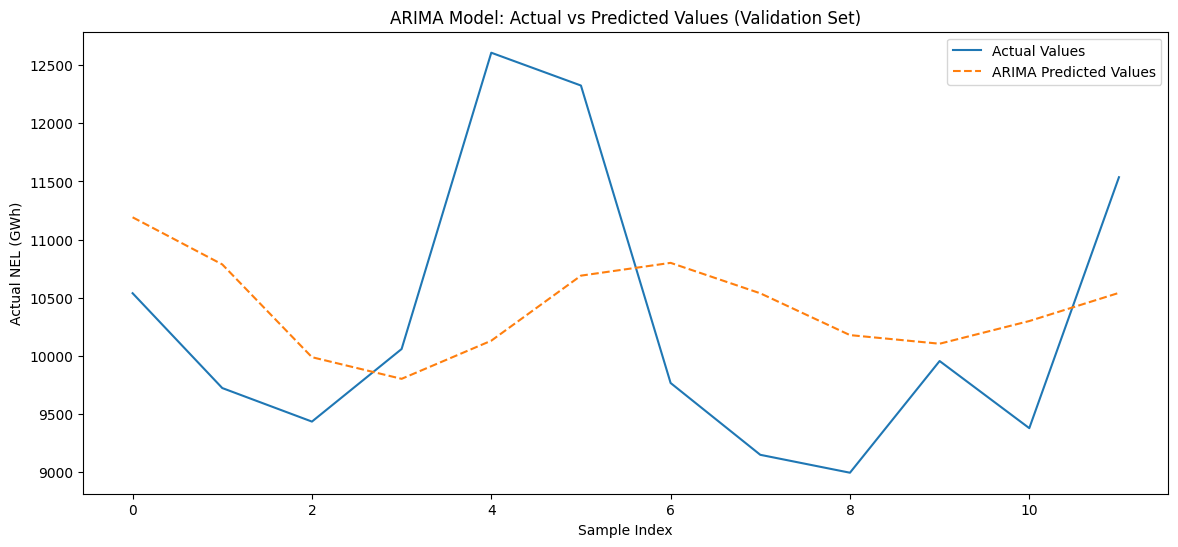

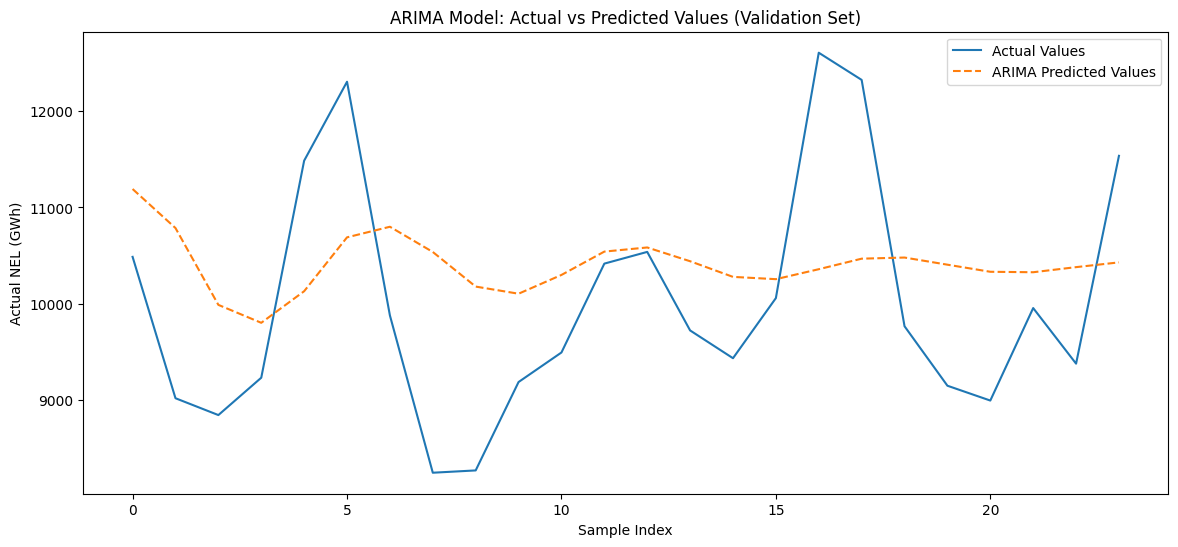

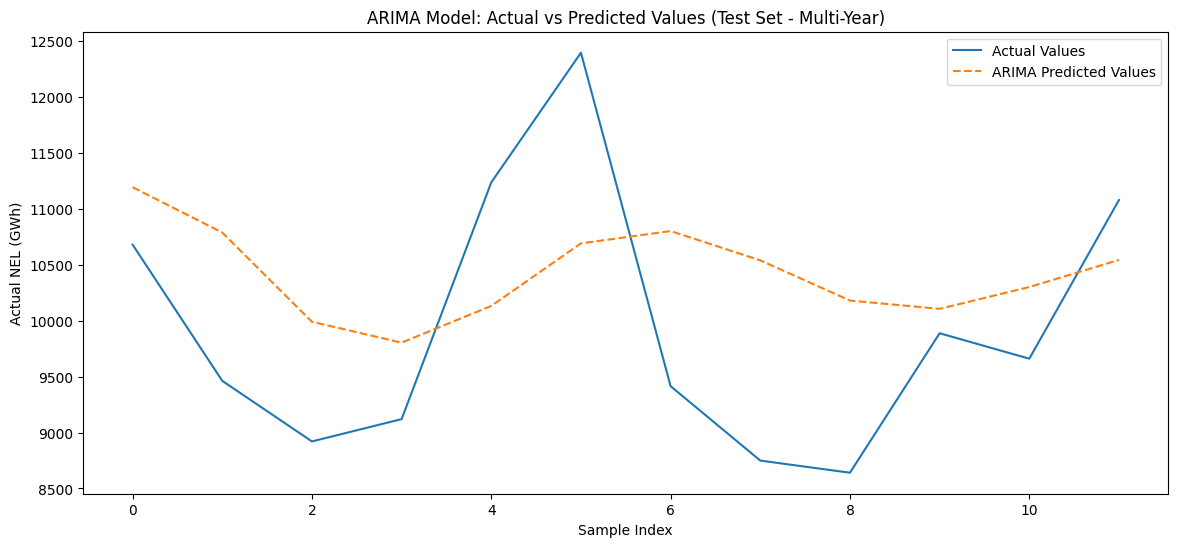

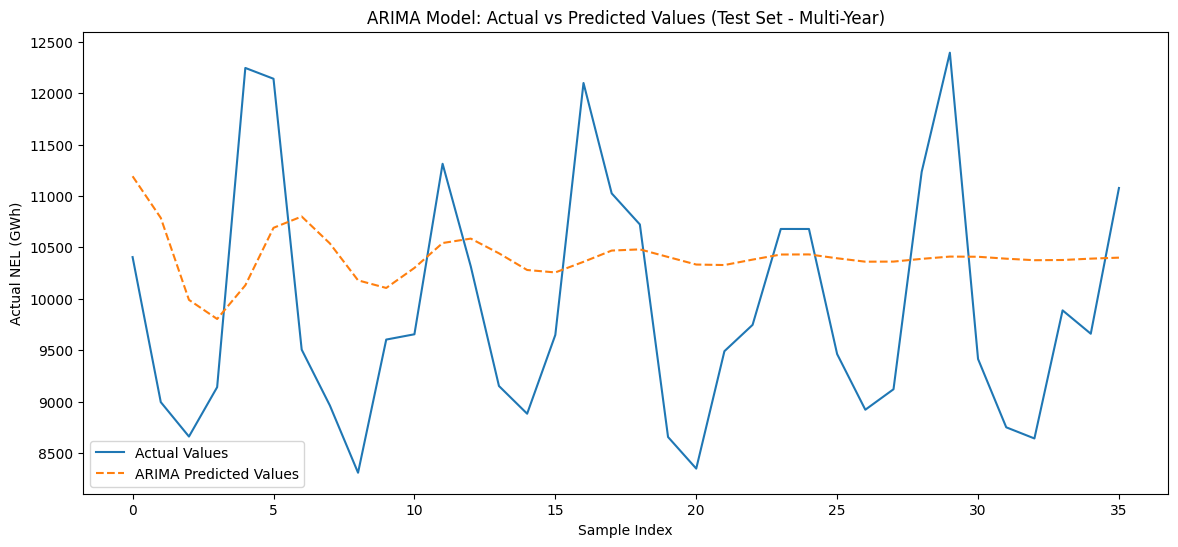

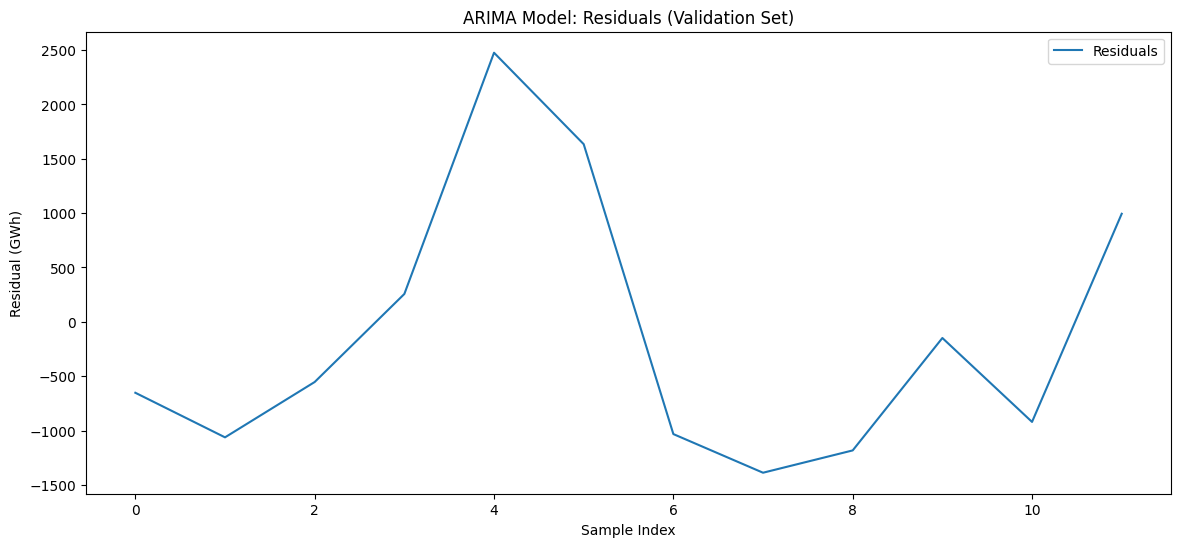

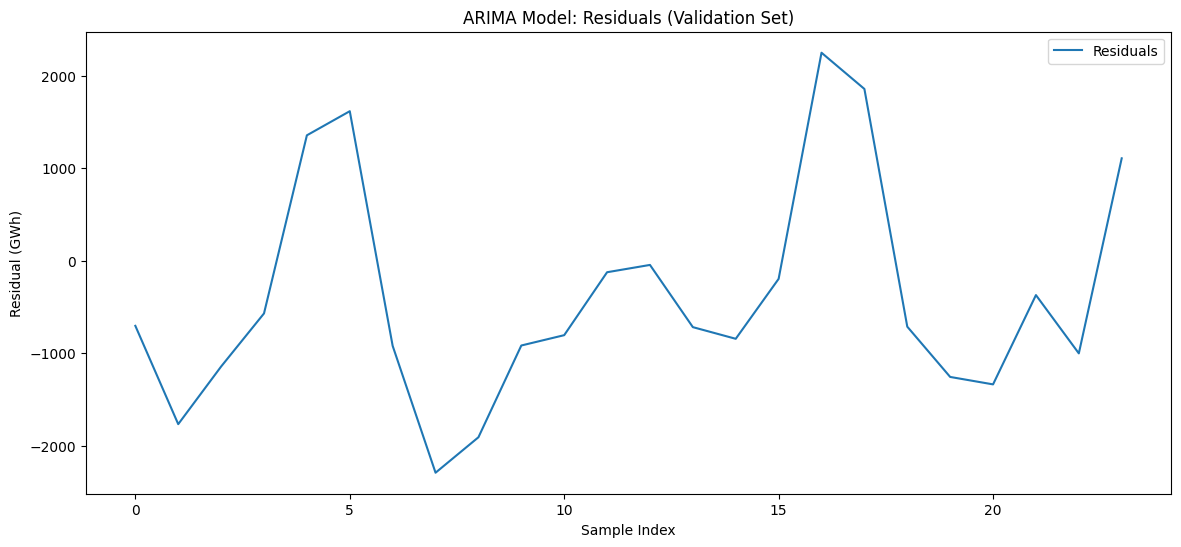

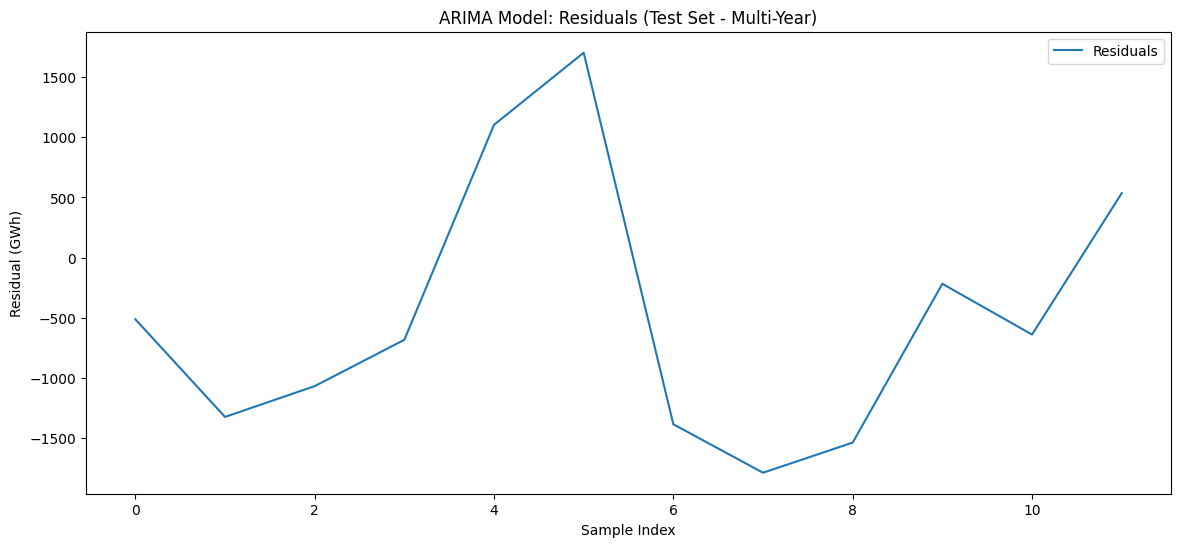

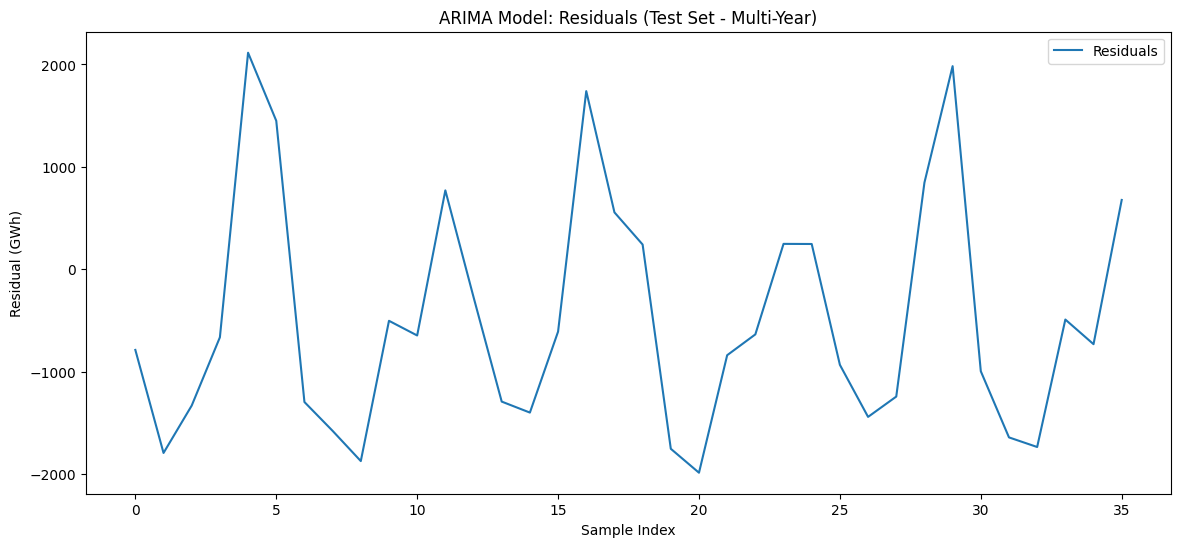

In [28]:
# Plot actual vs. predicted values for the validation set (ARIMA Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_val_single.values, label='Actual Values')
plt.plot(y_val_arima_single.values, label='ARIMA Predicted Values', linestyle='--')
plt.title('ARIMA Model: Actual vs Predicted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'ARIMAavpVS_S.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the validation set (ARIMA Model - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_val_multi.values, label='Actual Values')
plt.plot(y_val_arima_multi.values, label='ARIMA Predicted Values', linestyle='--')
plt.title('ARIMA Model: Actual vs Predicted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'ARIMAavpVS_M.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the single year test set (ARIMA Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test_single.values, label='Actual Values')
plt.plot(y_test_arima_single.values, label='ARIMA Predicted Values', linestyle='--')
plt.title('ARIMA Model: Actual vs Predicted Values (Test Set - Multi-Year)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'ARIMAavpTS_S.png'))
plt.show()
plt.close()

# Plot actual vs. predicted values for the multi-year test set (ARIMA Model)
plt.figure(figsize=(14, 6))
plt.plot(y_test_multi.values, label='Actual Values')
plt.plot(y_test_arima_multi.values, label='ARIMA Predicted Values', linestyle='--')
plt.title('ARIMA Model: Actual vs Predicted Values (Test Set - Multi-Year)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'ARIMAavpTS_M.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (ARIMA Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_val_single.values - y_val_arima_single.values, label='Residuals')
plt.title('ARIMA Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'ARIMArVS_S.png'))
plt.show()
plt.close()

# Plot residuals for the validation set (ARIMA Model- Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_val_multi.values - y_val_arima_multi.values, label='Residuals')
plt.title('ARIMA Model: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'ARIMArVS_M.png'))
plt.show()
plt.close()

# Plot residuals for the multi-year test set (ARIMA Model - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_test_single.values - y_test_arima_single.values, label='Residuals')
plt.title('ARIMA Model: Residuals (Test Set - Multi-Year)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'ARIMArTS_S.png'))
plt.show()
plt.close()

# Plot residuals for the multi-year test set (ARIMA Model - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_test_multi.values - y_test_arima_multi.values, label='Residuals')
plt.title('ARIMA Model: Residuals (Test Set - Multi-Year)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig(os.path.join(output_dir, 'ARIMArTS_M.png'))
plt.show()
plt.close()


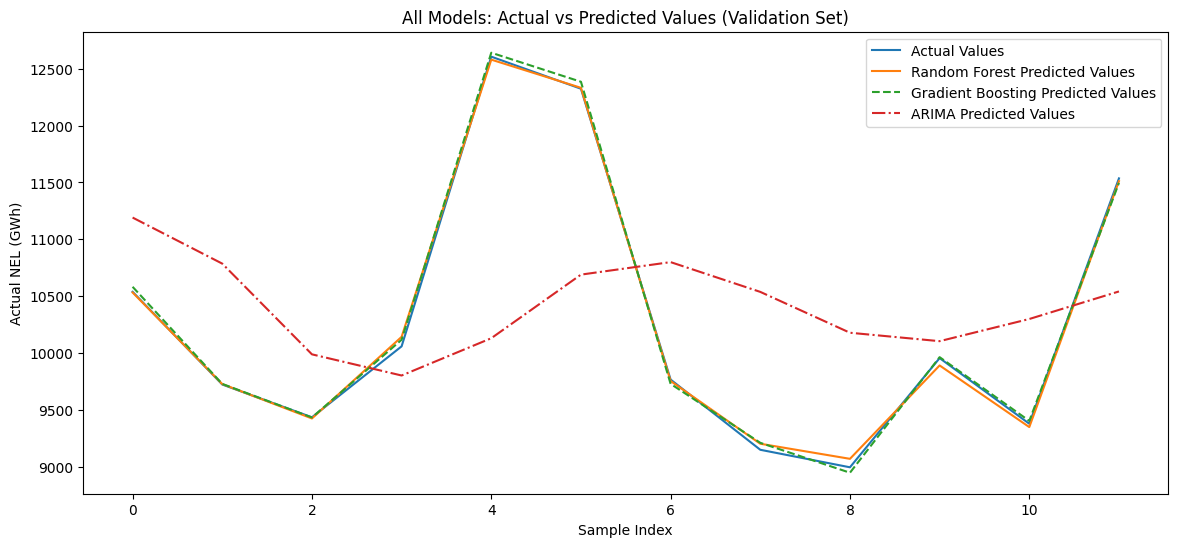

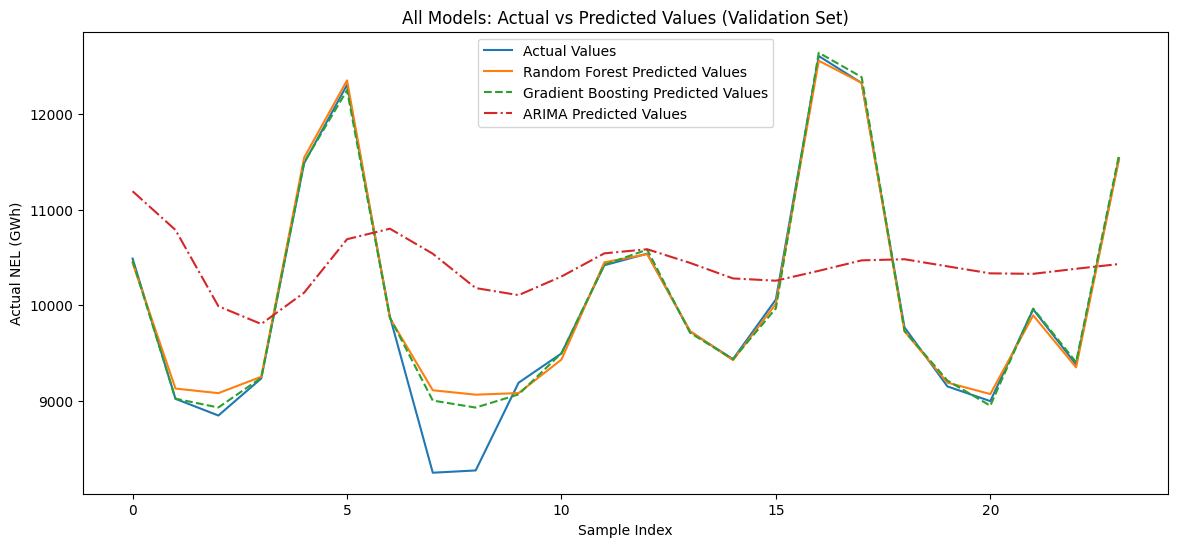

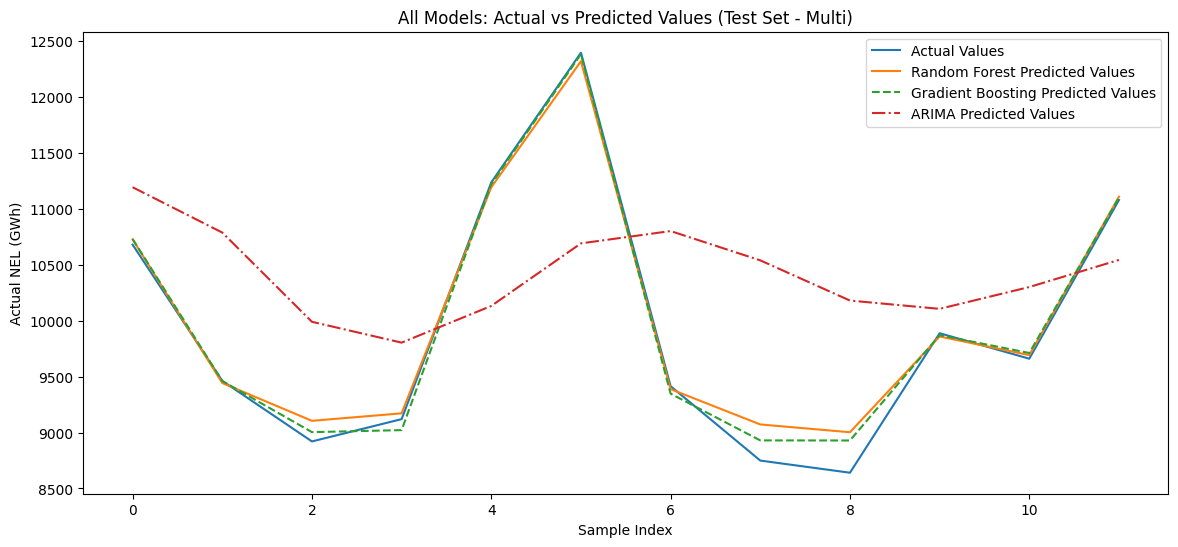

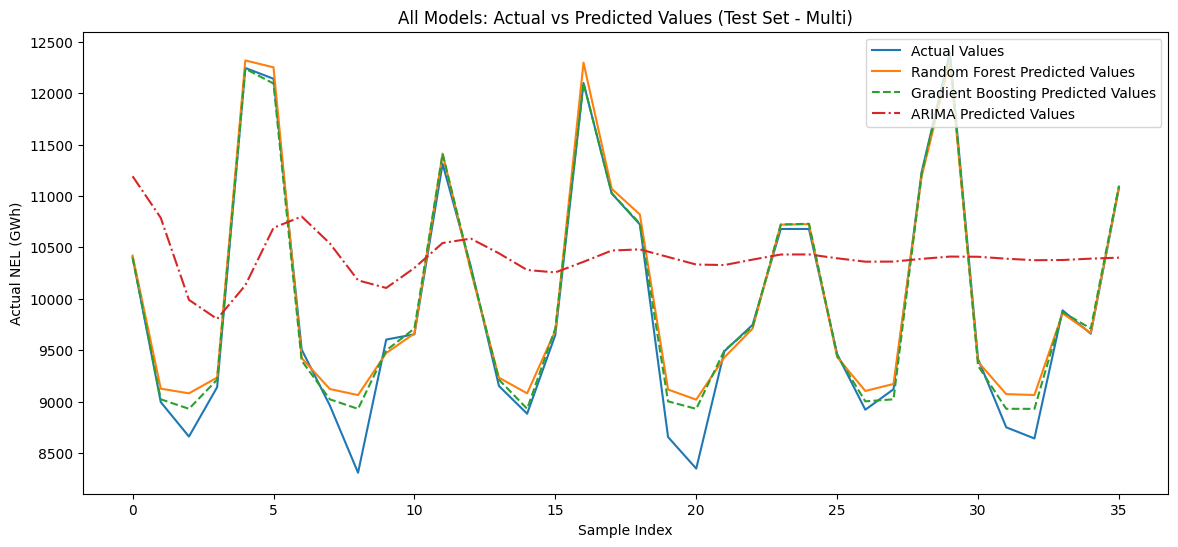

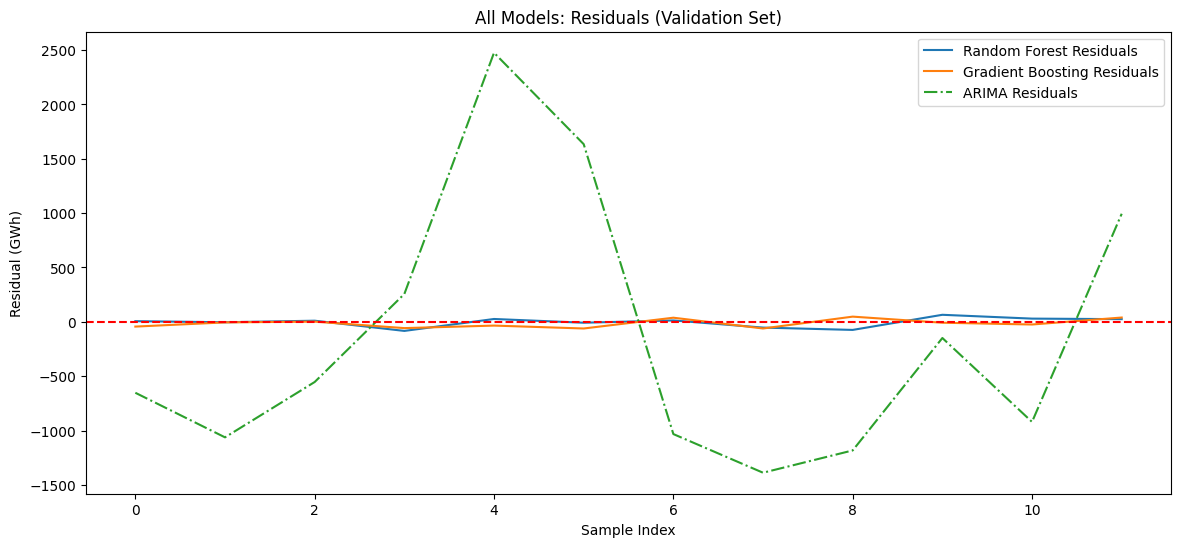

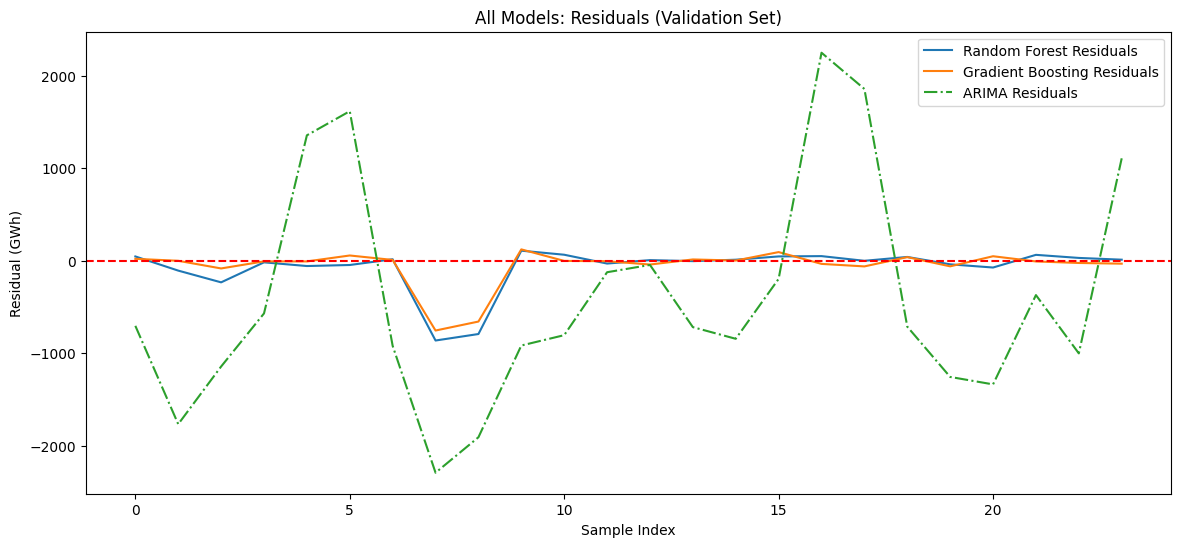

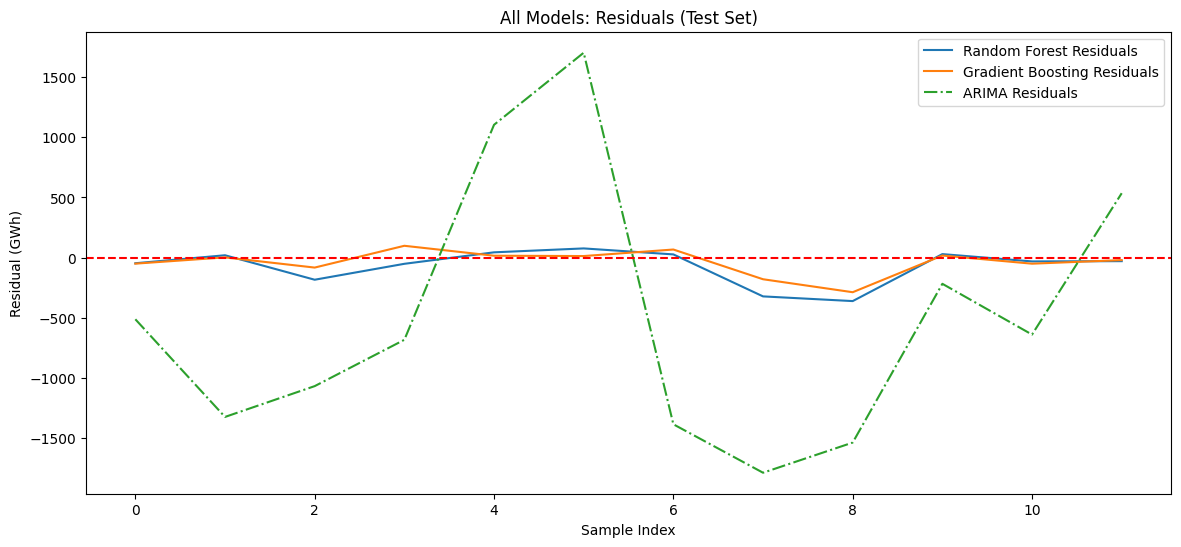

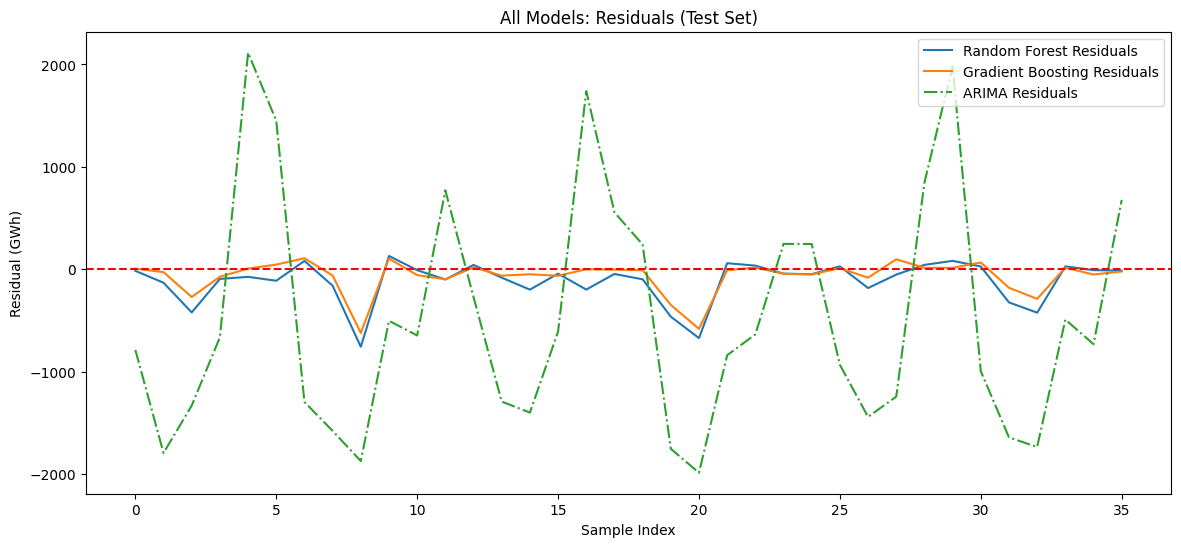

In [29]:
# Plot actual vs. predicted values for the validation set (All Models - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_val_single.values, label='Actual Values')
plt.plot(y_val_randomforest_single, label='Random Forest Predicted Values')
plt.plot(y_val_gradientboost_single, label='Gradient Boosting Predicted Values', linestyle='--')
plt.plot(y_val_arima_single.values, label='ARIMA Predicted Values', linestyle='-.')
plt.title('All Models: Actual vs Predicted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig('plots/allModelavpVS_S.png')
plt.show()
plt.close()

# Plot actual vs. predicted values for the validation set (All Models - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_val_multi.values, label='Actual Values')
plt.plot(y_val_randomforest_multi, label='Random Forest Predicted Values')
plt.plot(y_val_gradientboost_multi, label='Gradient Boosting Predicted Values', linestyle='--')
plt.plot(y_val_arima_multi.values, label='ARIMA Predicted Values', linestyle='-.')
plt.title('All Models: Actual vs Predicted Values (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig('plots/allModelavpVS_M.png')
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (All Models - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_test_single.values, label='Actual Values')
plt.plot(y_test_randomforest_single, label='Random Forest Predicted Values')
plt.plot(y_test_gradientboost_single, label='Gradient Boosting Predicted Values', linestyle='--')
plt.plot(y_test_arima_single.values, label='ARIMA Predicted Values', linestyle='-.')
plt.title('All Models: Actual vs Predicted Values (Test Set - Multi)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig('plots/allModelavpTS_S.png')
plt.show()
plt.close()

# Plot actual vs. predicted values for the test set (All Models - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_test_multi.values, label='Actual Values')
plt.plot(y_test_randomforest_multi, label='Random Forest Predicted Values')
plt.plot(y_test_gradientboost_multi, label='Gradient Boosting Predicted Values', linestyle='--')
plt.plot(y_test_arima_multi.values, label='ARIMA Predicted Values', linestyle='-.')
plt.title('All Models: Actual vs Predicted Values (Test Set - Multi)')
plt.xlabel('Sample Index')
plt.ylabel('Actual NEL (GWh)')
plt.legend()
plt.savefig('plots/allModelavpTS_M.png')
plt.show()
plt.close()

# Plot residuals vs actual values for the validation set (All Models - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_val_single.values - y_val_randomforest_single, label='Random Forest Residuals')
plt.plot(y_val_single.values - y_val_gradientboost_single, label='Gradient Boosting Residuals')
plt.plot(y_val_single.values - y_val_arima_single.values, label='ARIMA Residuals', linestyle='-.')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('All Models: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig('plots/allModelrvaVS_S.png')
plt.show()
plt.close()

# Plot residuals vs actual values for the validation set (All Models - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_val_multi.values - y_val_randomforest_multi, label='Random Forest Residuals')
plt.plot(y_val_multi.values - y_val_gradientboost_multi, label='Gradient Boosting Residuals')
plt.plot(y_val_multi.values - y_val_arima_multi.values, label='ARIMA Residuals', linestyle='-.')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('All Models: Residuals (Validation Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig('plots/allModelrvaVS_M.png')
plt.show()
plt.close()

# Plot residuals vs actual values for the test set (All Models - Single)
plt.figure(figsize=(14, 6))
plt.plot(y_test_single.values - y_test_randomforest_single, label='Random Forest Residuals')
plt.plot(y_test_single.values - y_test_gradientboost_single, label='Gradient Boosting Residuals')
plt.plot(y_test_single.values - y_test_arima_single.values, label='ARIMA Residuals', linestyle='-.')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('All Models: Residuals (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig('plots/allModelrvaTS_S.png')
plt.show()
plt.close()

# Plot residuals vs actual values for the test set (All Models - Multi)
plt.figure(figsize=(14, 6))
plt.plot(y_test_multi.values - y_test_randomforest_multi, label='Random Forest Residuals')
plt.plot(y_test_multi.values - y_test_gradientboost_multi, label='Gradient Boosting Residuals')
plt.plot(y_test_multi.values - y_test_arima_multi.values, label='ARIMA Residuals', linestyle='-.')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('All Models: Residuals (Test Set)')
plt.xlabel('Sample Index')
plt.ylabel('Residual (GWh)')
plt.legend()
plt.savefig('plots/allModelrvaTS_M.png')
plt.show()
plt.close()

In [30]:
# Metrics for Random Forest Forecasting Model - Single
rf_forecast_metrics_single = {
    'Model': 'Random Forest',
    # 'Task': 'Forecasting',
    'Validation MAE': val_randomforest_mae_single,
    'Validation MSE': val_randomforest_mse_single,
    'Validation MAPE': val_randomforest_mape_single,
    'Validation RMSE': val_randomforest_rmse_single,
    'Validation R²': val_randomforest_r2_single,
    'Validation MBD': val_randomforest_mbd_single,
    'Validation sMAPE': val_randomforest_smape_single,
    'Test MAE': test_randomforest_mae_single,
    'Test MSE': test_randomforest_mse_single,
    'Test MAPE': test_randomforest_mape_single,
    'Test RMSE': test_randomforest_rmse_single,
    'Test R²': test_randomforest_r2_single,
    'Test MBD': test_randomforest_mbd_single,
    'Test sMAPE': test_randomforest_smape_single
}

# Metrics for Random Forest Forecasting Model - Multi
rf_forecast_metrics_multi = {
    'Model': 'Random Forest',
    # 'Task': 'Forecasting',
    'Validation MAE': val_randomforest_mae_multi,
    'Validation MSE': val_randomforest_mse_multi,
    'Validation MAPE': val_randomforest_mape_multi,
    'Validation RMSE': val_randomforest_rmse_multi,
    'Validation R²': val_randomforest_r2_multi,
    'Validation MBD': val_randomforest_mbd_multi,
    'Validation sMAPE': val_randomforest_smape_multi,
    'Test MAE': test_randomforest_mae_multi,
    'Test MSE': test_randomforest_mse_multi,
    'Test MAPE': test_randomforest_mape_multi,
    'Test RMSE': test_randomforest_rmse_multi,
    'Test R²': test_randomforest_r2_multi,
    'Test MBD': test_randomforest_mbd_multi,
    'Test sMAPE': test_randomforest_smape_multi
}

In [31]:
# Metrics for Random Forest Error Correction Model
# rf_error_correction_metrics = {
#     'Model': 'Random Forest',
#     'Task': 'Error Correction',
#     'Validation MAE': val_corrected_mae,
#     'Validation MSE': val_corrected_mse,
#     'Validation MAPE': val_corrected_mape,
#     'Validation RMSE': val_corrected_rmse,
#     'Validation R²': val_corrected_r2,
#     'Validation MBD': val_corrected_mbd,
#     'Validation sMAPE': val_corrected_smape,
#     'Test MAE': test_corrected_mae,
#     'Test MSE': test_corrected_mse,
#     'Test MAPE': test_corrected_mape,
#     'Test RMSE': test_corrected_rmse,
#     'Test R²': test_corrected_r2,
#     'Test MBD': test_corrected_mbd,
#     'Test sMAPE': test_corrected_smape
# }

In [32]:
# Metrics for Gradient Boosting Forecasting Model - Single
gb_forecast_metrics_single = {
    'Model': 'Gradient Boosting',
    # 'Task': 'Forecasting',
    'Validation MAE': val_gradientboost_mae_single,
    'Validation MSE': val_gradientboost_mse_single,
    'Validation MAPE': val_gradientboost_mape_single,
    'Validation RMSE': val_gradientboost_rmse_single,
    'Validation R²': val_gradientboost_r2_single,
    'Validation MBD': val_gradientboost_mbd_single,
    'Validation sMAPE': val_gradientboost_smape_single,
    'Test MAE': test_gradientboost_mae_single,
    'Test MSE': test_gradientboost_mse_single,
    'Test MAPE': test_gradientboost_mape_single,
    'Test RMSE': test_gradientboost_rmse_single,
    'Test R²': test_gradientboost_r2_single,
    'Test MBD': test_gradientboost_mbd_single,
    'Test sMAPE': test_gradientboost_smape_single
}

# Metrics for Gradient Boosting Forecasting Model - Multi
gb_forecast_metrics_multi = {
    'Model': 'Gradient Boosting',
    # 'Task': 'Forecasting',
    'Validation MAE': val_gradientboost_mae_multi,
    'Validation MSE': val_gradientboost_mse_multi,
    'Validation MAPE': val_gradientboost_mape_multi,
    'Validation RMSE': val_gradientboost_rmse_multi,
    'Validation R²': val_gradientboost_r2_multi,
    'Validation MBD': val_gradientboost_mbd_multi,
    'Validation sMAPE': val_gradientboost_smape_multi,
    'Test MAE': test_gradientboost_mae_multi,
    'Test MSE': test_gradientboost_mse_multi,
    'Test MAPE': test_gradientboost_mape_multi,
    'Test RMSE': test_gradientboost_rmse_multi,
    'Test R²': test_gradientboost_r2_multi,
    'Test MBD': test_gradientboost_mbd_multi,
    'Test sMAPE': test_gradientboost_smape_multi
}

In [33]:
# Metrics for Gradient Boosting Error Correction Model
# gb_error_correction_metrics = {
#     'Model': 'Gradient Boosting',
#     'Task': 'Error Correction',
#     'Validation MAE': val_corrected_gb_mae,
#     'Validation MSE': val_corrected_gb_mse,
#     'Validation MAPE': val_corrected_gb_mape,
#     'Validation RMSE': val_corrected_gb_rmse,
#     'Validation R²': val_corrected_gb_r2,
#     'Validation MBD': val_corrected_gb_mbd,
#     'Validation sMAPE': val_corrected_gb_smape,
#     'Test MAE': test_corrected_gb_mae,
#     'Test MSE': test_corrected_gb_mse,
#     'Test MAPE': test_corrected_gb_mape,
#     'Test RMSE': test_corrected_gb_rmse,
#     'Test R²': test_corrected_gb_r2,
#     'Test MBD': test_corrected_gb_mbd,
#     'Test sMAPE': test_corrected_gb_smape
# }

In [34]:
# Metrics for ARIMA model - Single
arima_metrics_single = {
    'Model': 'ARIMA',
    # 'Task': 'Forecasting',
    'Validation MAE': val_arima_mae_single,
    'Validation MSE': val_arima_mse_single,
    'Validation MAPE': val_arima_mape_single,
    'Validation RMSE': val_arima_rmse_single,
    'Validation R²': val_arima_r2_single,
    'Validation MBD': val_arima_mbd_single,
    'Validation sMAPE': val_arima_smape_single,
    'Test MAE': test_arima_mae_single,
    'Test MSE': test_arima_mse_single,
    'Test MAPE': test_arima_mape_single,
    'Test RMSE': test_arima_rmse_single,
    'Test R²': test_arima_r2_single,
    'Test MBD': test_arima_mbd_single,
    'Test sMAPE': test_arima_smape_single
}

# Metrics for ARIMA model - Multi
arima_metrics_multi = {
    'Model': 'ARIMA',
    # 'Task': 'Forecasting',
    'Validation MAE': val_arima_mae_multi,
    'Validation MSE': val_arima_mse_multi,
    'Validation MAPE': val_arima_mape_multi,
    'Validation RMSE': val_arima_rmse_multi,
    'Validation R²': val_arima_r2_multi,
    'Validation MBD': val_arima_mbd_multi,
    'Validation sMAPE': val_arima_smape_multi,
    'Test MAE': test_arima_mae_multi,
    'Test MSE': test_arima_mse_multi,
    'Test MAPE': test_arima_mape_multi,
    'Test RMSE': test_arima_rmse_multi,
    'Test R²': test_arima_r2_multi,
    'Test MBD': test_arima_mbd_multi,
    'Test sMAPE': test_arima_smape_multi
}


In [35]:
# Combine all metrics into a single DataFrame
# all_metrics_df = pd.DataFrame([
#     rf_forecast_metrics, rf_error_correction_metrics,
#     gb_forecast_metrics, gb_error_correction_metrics
# ])
# all_metrics_df = pd.DataFrame([
#     rf_forecast_metrics, 
#     gb_forecast_metrics
# ])
all_metrics_df_single = pd.DataFrame([
    rf_forecast_metrics_single, 
    gb_forecast_metrics_single,
    arima_metrics_single
])

all_metrics_df_multi = pd.DataFrame([
    rf_forecast_metrics_multi, 
    gb_forecast_metrics_multi,
    arima_metrics_multi
])

# Save to CSV
all_metrics_df_single.to_csv('model_comparison_metrics_single.csv', index=False)
all_metrics_df_multi.to_csv('model_comparison_metrics_multi.csv', index=False)

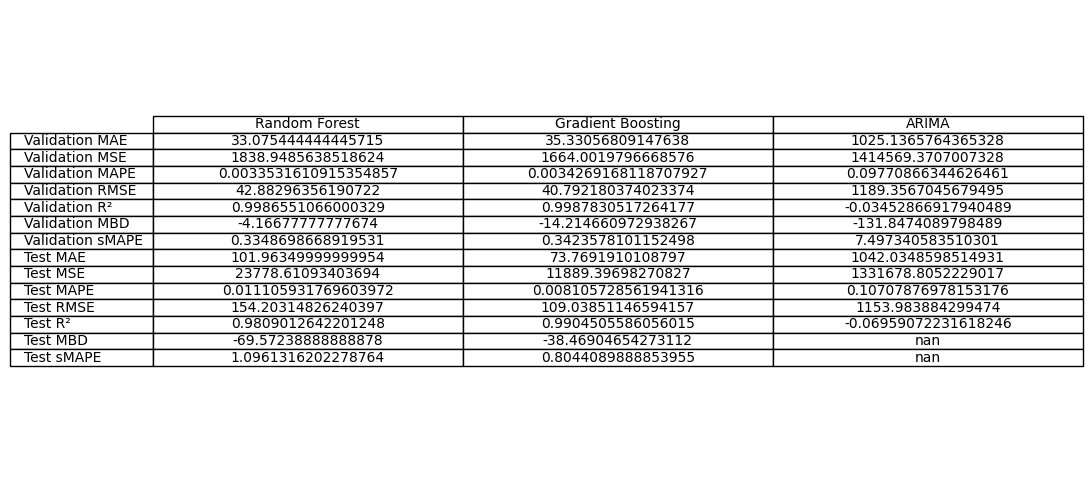

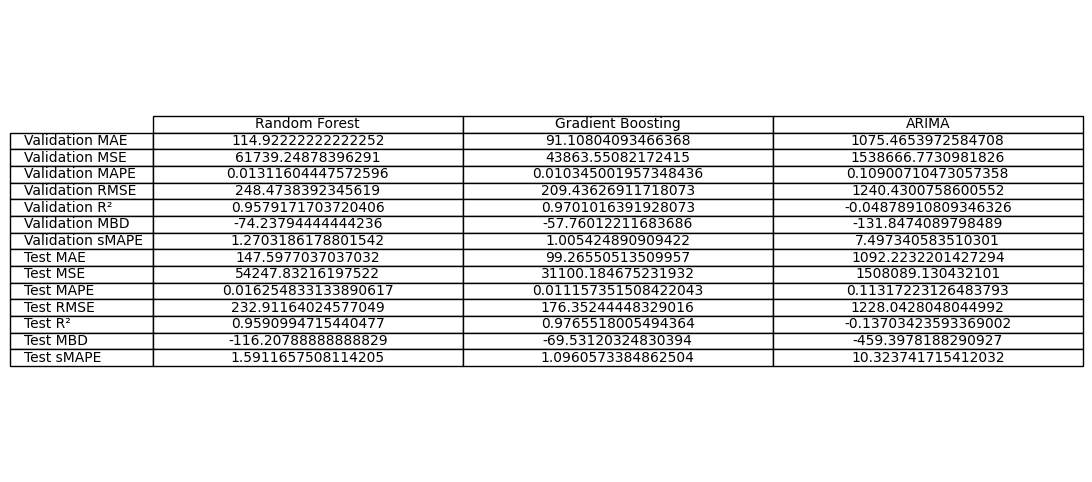

In [36]:
# Set the model names as the index - Single
# all_metrics_df.set_index('Model', inplace=True)
transposed_metrics_df_single = all_metrics_df_single.set_index('Model').T

# Plot the table
fig, ax = plt.subplots(figsize=(12, 6)) 
ax.axis('tight')
ax.axis('off')

# Create table plot
tbl_single = table(ax, transposed_metrics_df_single, loc='center', cellLoc='center')

# Save the table as an image
plt.savefig('model_metrics_table_S.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# Set the model names as the index - Multi
transposed_metrics_df_multi = all_metrics_df_multi.set_index('Model').T
# Plot the table
fig, ax = plt.subplots(figsize=(12, 6)) 
ax.axis('tight')
ax.axis('off')

# Create table plot
tbl_multi = table(ax, transposed_metrics_df_multi, loc='center', cellLoc='center')

# Save the table as an image
plt.savefig('model_metrics_table_M.png', bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [37]:
# # Load the saved metrics
# loaded_metrics_df = pd.read_csv('model_comparison_metrics.csv')

# # Filter data for plotting
# # forecasting_metrics = loaded_metrics_df[loaded_metrics_df['Task'] == 'Forecasting']

# # Normalize or log-scale MSE and RMSE to bring them to a comparable scale
# # forecasting_metrics['Validation MSE'] = np.log1p(forecasting_metrics['Validation MSE'])
# # forecasting_metrics['Validation RMSE'] = np.log1p(forecasting_metrics['Validation RMSE'])
# # forecasting_metrics['Test MSE'] = np.log1p(forecasting_metrics['Test MSE'])
# # forecasting_metrics['Test RMSE'] = np.log1p(forecasting_metrics['Test RMSE'])
# # error_correction_metrics = loaded_metrics_df[loaded_metrics_df['Task'] == 'Error Correction']

# # Plot comparison with values and save plots
# def plot_metrics_comparison(df, task, filename):
#     metrics = df.columns[2:]  # Exclude 'Model' and 'Task' columns
#     models = df['Model']
    
#     x = np.arange(len(metrics))
#     width = 0.25
    
#     fig, ax = plt.subplots(figsize=(14, 8))
#     rects1 = ax.bar(x - width, df.iloc[0, 2:], width, label=models.iloc[0])
#     rects2 = ax.bar(x, df.iloc[1, 2:], width, label=models.iloc[1])
#     rects3 = ax.bar(x + width, df.iloc[2, 2:], width, label=models.iloc[2])

#     ax.set_xlabel('Metrics')
#     ax.set_ylabel('Values')
#     ax.set_title(f'{task} Model Comparison: Random Forest vs Gradient Boosting vs Arima')
#     ax.set_xticks(x)
#     ax.set_xticklabels(metrics, rotation=45, ha="right")
#     ax.legend()
    
#     # Annotate values on bars
#     def annotate_bars(rects):
#         for rect in rects:
#             height = rect.get_height()
#             ax.annotate(f'{height:.2f}',
#                         xy=(rect.get_x() + rect.get_width() / 2, height),
#                         xytext=(0, 3),  # 3 points vertical offset
#                         textcoords="offset points",
#                         ha='center', va='bottom')

#     annotate_bars(rects1)
#     annotate_bars(rects2)
#     annotate_bars(rects3)

#     plt.savefig(filename)
#     plt.show()
#     plt.close()

# # Plot and save forecasting metrics comparison
# plot_metrics_comparison(loaded_metrics_df, 'Forecasting', 'plots/fc_metrics_comparison.png')

# # Plot and save error correction metrics comparison
# # plot_metrics_comparison(error_correction_metrics, 'Error Correction', 'plots/ec_metrics_comparison.png')

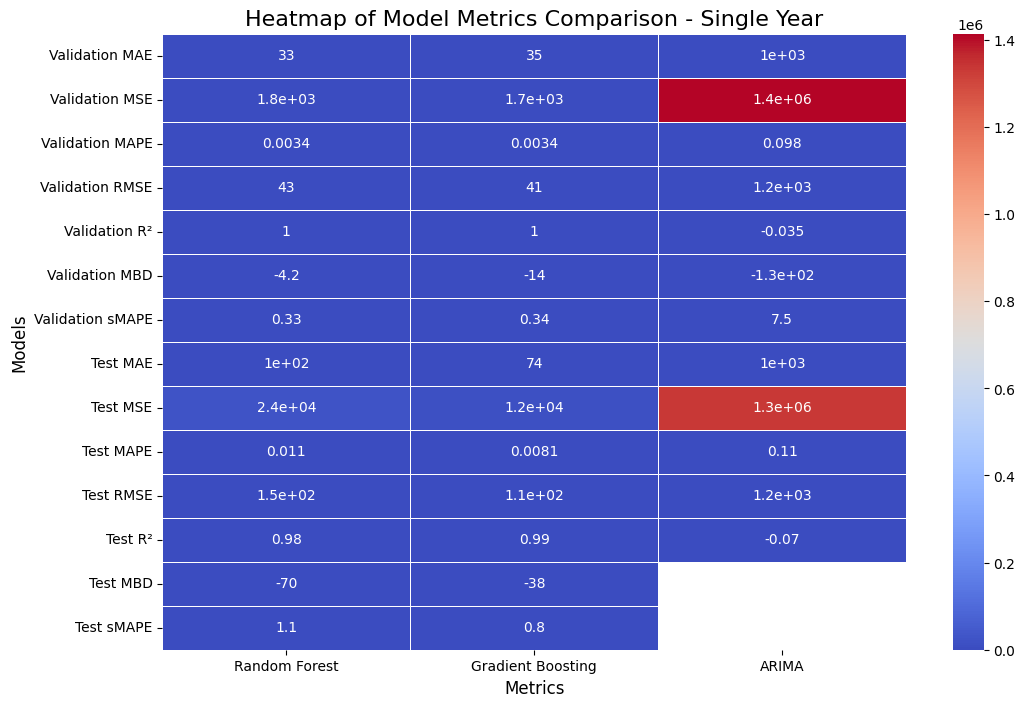

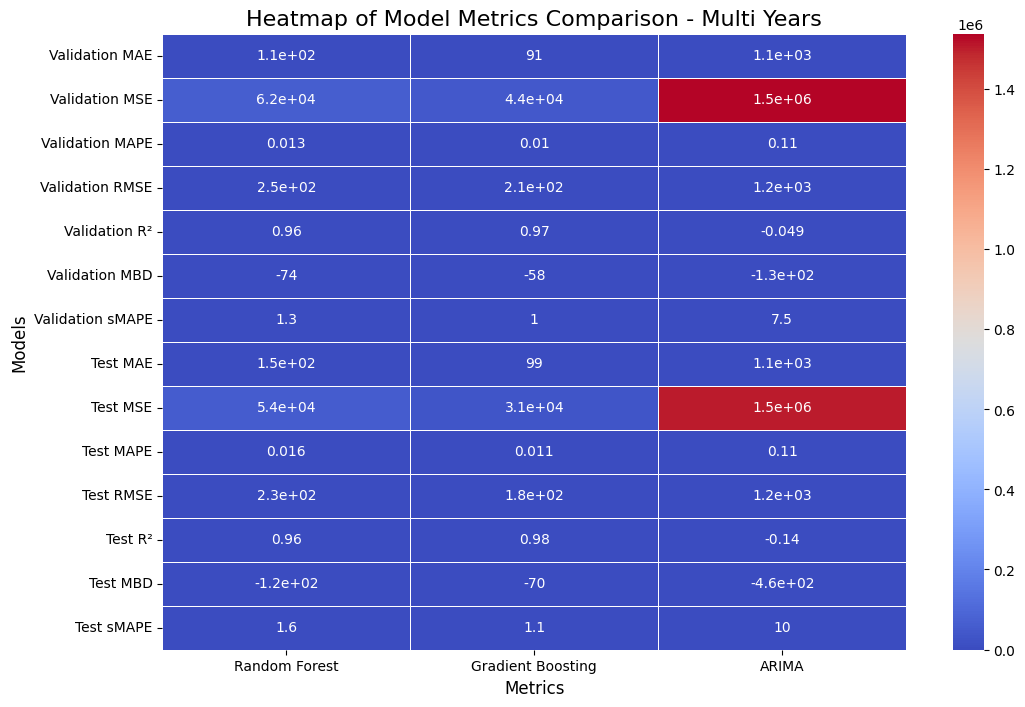

In [38]:
# Create a heatmap - Single
plt.figure(figsize=(12, 8))
sns.heatmap(transposed_metrics_df_single, annot=True, cmap='coolwarm', linewidths=0.5)

# Set title and labels
plt.title('Heatmap of Model Metrics Comparison - Single Year', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Models', fontsize=12)

# Save the heatmap as an image
plt.savefig('plots/model_metrics_heatmap_S.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()
plt.close()

# Create a heatmap - Multi
plt.figure(figsize=(12, 8))
sns.heatmap(transposed_metrics_df_multi, annot=True, cmap='coolwarm', linewidths=0.5)

# Set title and labels
plt.title('Heatmap of Model Metrics Comparison - Multi Years', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Models', fontsize=12)

# Save the heatmap as an image
plt.savefig('plots/model_metrics_heatmap_M.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()
plt.close()

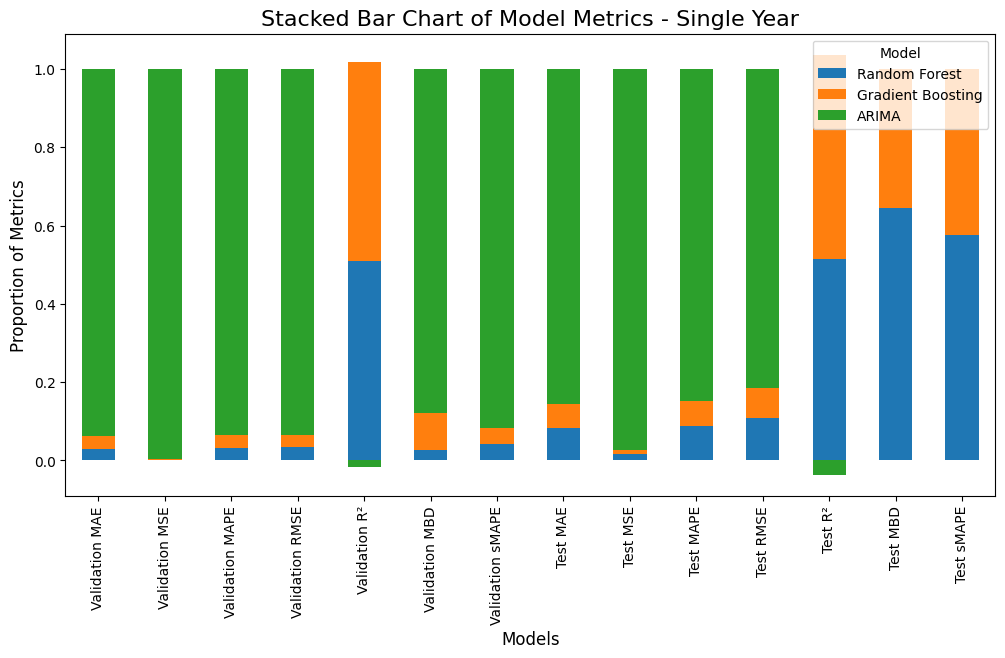

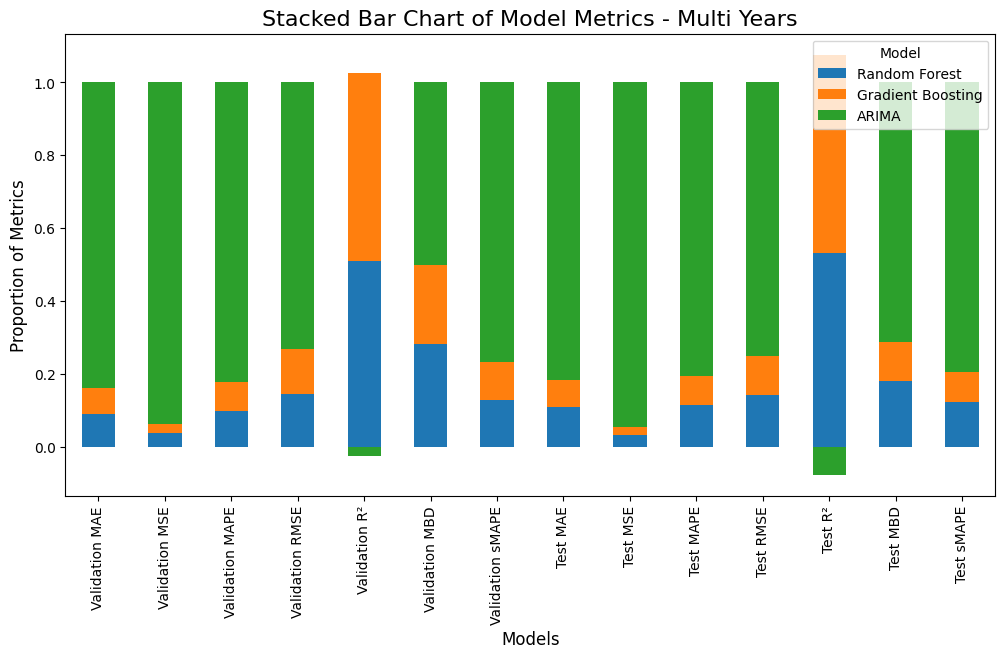

In [39]:
df_normalized = transposed_metrics_df_single.div(transposed_metrics_df_single.sum(axis=1), axis=0)

# Create the stacked bar chart
ax = df_normalized.plot(kind='bar', stacked=True, figsize=(12, 6))

# Set title and labels for the stacked bar chart
plt.title('Stacked Bar Chart of Model Metrics - Single Year', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Proportion of Metrics', fontsize=12)

# Save the stacked bar chart as an image
plt.savefig('plots/model_metrics_stacked_bar_chart_S.png', bbox_inches='tight', dpi=300)

# Show the stacked bar chart
plt.show()
plt.close()

df_normalized = transposed_metrics_df_multi.div(transposed_metrics_df_multi.sum(axis=1), axis=0)

# Create the stacked bar chart
ax = df_normalized.plot(kind='bar', stacked=True, figsize=(12, 6))

# Set title and labels for the stacked bar chart
plt.title('Stacked Bar Chart of Model Metrics - Multi Years', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Proportion of Metrics', fontsize=12)

# Save the stacked bar chart as an image
plt.savefig('plots/model_metrics_stacked_bar_chart_M.png', bbox_inches='tight', dpi=300)

# Show the stacked bar chart
plt.show()
plt.close()